##  Données Utilisées
- **Source** : `online_retail_II.xlsx` (transactions e-commerce)
- **Période** : 2009-2011
- **Variables clés** : Invoice, StockCode, Description, Quantity, InvoiceDate, Price, CustomerID, Country


### Qu'est-ce que l'Analyse RFM ?

L'analyse RFM est une technique de segmentation client basée sur trois métriques clés :

- **R (Récence)** : Délai depuis la dernière commande
- **F (Fréquence)** : Nombre de commandes sur la période
- **M (Monetary)** : Montant total dépensé

###  Objectifs de cette Analyse

1. **Segmentation automatique** des clients selon leur comportement d'achat
2. **Comparaison de 3 algorithmes** de clustering pour identifier le plus performant
3. **Évaluation quantitative** avec métriques internes (Silhouette, Calinski-Harabasz) et externes (F1, ARI)
4. **Détection d'anomalies** dans les transactions pour améliorer la qualité des données
5. **Visualisations interactives** pour faciliter l'interprétation des résultats

## 1) Imports et Configuration

Tous les packages nécessaires pour l'analyse complète

In [2]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

# Manipulation des données
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors

# Métriques d'évaluation
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score, f1_score
)

# Optimisation
from scipy.optimize import linear_sum_assignment

# Configuration des affichages
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)
plt.rcParams['figure.figsize'] = (12, 8)

# Chemin des données
DATA_PATH = r"c:/Users/hp/Desktop/DataMining/online_retail_II.xlsx"

print("Tous les packages importés avec succès!")
print(f"Chemin des données: {DATA_PATH}")
print(f"Vérification du fichier: {'Trouvé' if os.path.exists(DATA_PATH) else 'Non trouvé'}")


Tous les packages importés avec succès!
Chemin des données: c:/Users/hp/Desktop/DataMining/online_retail_II.xlsx
Vérification du fichier: Trouvé


## 2) Nettoyage et Préparation des Données

Objectifs du Nettoyage

1. **Charger les données** depuis le fichier Excel
2. **Identifier les problèmes** : valeurs manquantes, doublons, incohérences
3. **Nettoyer les données** tout en préservant les informations importantes
4. **Préparer les features** pour l'analyse RFM
5. **Conserver les CustomerID manquants** pour la détection d'anomalies


In [3]:
# Chargement et Inspection Initiale des Données

print("Chargement des données...")
raw_df = pd.read_excel(DATA_PATH)

print(f"Shape initial: {raw_df.shape}")
print(f"Colonnes: {list(raw_df.columns)}")

# Harmonisation des noms de colonnes (différentes versions du dataset)
col_mapping = {
    'Invoice': 'Invoice',
    'InvoiceNo': 'Invoice', 
    'StockCode': 'StockCode',
    'Description': 'Description',
    'Quantity': 'Quantity',
    'InvoiceDate': 'InvoiceDate',
    'UnitPrice': 'Price',
    'Price': 'Price',
    'Customer ID': 'CustomerID',
    'CustomerID': 'CustomerID',
    'Country': 'Country'
}

df = raw_df.rename(columns={c: col_mapping.get(c, c) for c in raw_df.columns})

print("\n Aperçu des données:")
print(df.head())

print("\n Types de données:")
print(df.dtypes)

print("\n Statistiques descriptives:")
print(df.describe())


Chargement des données...
Shape initial: (525461, 8)
Colonnes: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

 Aperçu des données:
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  CustomerID         Country
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00   6.95     13085.0  United Kingdom
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.0  United Kingdom
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.0  United Kingdom
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48 2009-12-01 07:45:00   2.10     13085.0  United Kingdom
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24 2009-12-01 07:45:00   1.25     13085.0  United Kingdom

 Types de données:
Invoice                object
StockCode              object
D

In [4]:
# Diagnostic des Problèmes de Données

print(" DIAGNOSTIC COMPLET DES DONNÉES")
print("="*50)

# 1. Valeurs manquantes
print("\n 1) VALEURS MANQUANTES:")
missing_analysis = df.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_analysis / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Valeurs_Manquantes': missing_analysis,
    'Pourcentage': missing_pct
})
print(missing_df[missing_df['Valeurs_Manquantes'] > 0])

# 2. Types de données et conversions nécessaires
print("\n 2) CONVERSION DES TYPES:")
print("Conversion des dates...")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

print("Conversion des quantités et prix...")
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# 3. Analyse des quantités négatives (retours)
print("\n 3) ANALYSE DES RETOURS:")
negative_qty = (df['Quantity'] < 0).sum()
print(f"Lignes avec quantité négative (retours): {negative_qty:,} ({negative_qty/len(df)*100:.2f}%)")

# 4. Doublons
print("\n 4) DOUBLONS:")
duplicates = df.duplicated().sum()
print(f"Lignes dupliquées exactes: {duplicates:,} ({duplicates/len(df)*100:.2f}%)")

# 5. Période temporelle
print("\n 5) PÉRIODE TEMPORELLE:")
print(f"Période: {df['InvoiceDate'].min()} à {df['InvoiceDate'].max()}")
print(f"Durée: {(df['InvoiceDate'].max() - df['InvoiceDate'].min()).days} jours")

# 6. Clients uniques
print("\n 6) CLIENTS:")
total_customers = df['CustomerID'].nunique()
missing_customers = df['CustomerID'].isnull().sum()
print(f"Total clients uniques: {total_customers:,}")
print(f"Transactions sans CustomerID: {missing_customers:,} ({missing_customers/len(df)*100:.2f}%)")


 DIAGNOSTIC COMPLET DES DONNÉES

 1) VALEURS MANQUANTES:
             Valeurs_Manquantes  Pourcentage
CustomerID               107927        20.54
Description                2928         0.56

 2) CONVERSION DES TYPES:
Conversion des dates...
Conversion des quantités et prix...

 3) ANALYSE DES RETOURS:
Lignes avec quantité négative (retours): 12,326 (2.35%)

 4) DOUBLONS:
Lignes dupliquées exactes: 6,865 (1.31%)

 5) PÉRIODE TEMPORELLE:
Période: 2009-12-01 07:45:00 à 2010-12-09 20:01:00
Durée: 373 jours

 6) CLIENTS:
Total clients uniques: 4,383
Transactions sans CustomerID: 107,927 (20.54%)


In [33]:
# Nettoyage des Données

print(" NETTOYAGE DES DONNÉES")
print("="*30)

# Copie pour le nettoyage
clean_df = df.copy()

# 1. Supprimer les lignes avec des champs critiques manquants
print(" 1) Suppression des lignes avec champs critiques manquants...")
before_clean = len(clean_df)

# Supprimer les lignes sans date, stockcode, ou description
clean_df = clean_df.dropna(subset=['InvoiceDate', 'StockCode', 'Description'])

# Supprimer les lignes avec quantité ou prix nuls/invalides
clean_df = clean_df[(clean_df['Quantity'].notna()) & (clean_df['Price'].notna())]
clean_df = clean_df[(clean_df['Quantity'] != 0) & (clean_df['Price'] != 0)]

after_clean = len(clean_df)
print(f"   Lignes supprimées: {before_clean - after_clean:,}")

# 2. Gérer les retours (quantités négatives)
print("\n 2) Gestion des retours...")
clean_df['IsReturn'] = clean_df['Quantity'] < 0
clean_df['LineAmount'] = clean_df['Quantity'] * clean_df['Price']

returns_count = clean_df['IsReturn'].sum()
print(f"   Retours identifiés: {returns_count:,} ({returns_count/len(clean_df)*100:.2f}%)")

# 3. Supprimer les doublons exacts
print("\n 3) Suppression des doublons...")
before_dedup = len(clean_df)
clean_df = clean_df.drop_duplicates()
after_dedup = len(clean_df)
print(f"   Doublons supprimés: {before_dedup - after_dedup:,}")

# 4. Nettoyage des descriptions
print("\n 4) Nettoyage des descriptions...")
clean_df['Description'] = clean_df['Description'].astype(str).str.strip()
clean_df['StockCode'] = clean_df['StockCode'].astype(str).str.strip()

# Résumé du nettoyage
print(f"\n NETTOYAGE TERMINÉ")
print(f"   Lignes initiales: {len(df):,}")
print(f"   Lignes finales: {len(clean_df):,}")
print(f"   Réduction: {((len(df) - len(clean_df))/len(df)*100):.1f}%")

# Aperçu des données nettoyées
print(f"\n APERÇU DES DONNÉES NETTOYÉES:")
print(clean_df.head())
clean_df.head()

 NETTOYAGE DES DONNÉES
 1) Suppression des lignes avec champs critiques manquants...
   Lignes supprimées: 3,687

 2) Gestion des retours...
   Retours identifiés: 10,205 (1.96%)

 3) Suppression des doublons...
   Doublons supprimés: 6,859

 4) Nettoyage des descriptions...

 NETTOYAGE TERMINÉ
   Lignes initiales: 525,461
   Lignes finales: 514,915
   Réduction: 2.0%

 APERÇU DES DONNÉES NETTOYÉES:
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  CustomerID         Country  IsReturn  LineAmount
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00   6.95     13085.0  United Kingdom     False        83.4
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.0  United Kingdom     False        81.0
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75     13085.0  United Kingdom     False        81.0
3  489434     22041  

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,IsReturn,LineAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,False,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,False,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,False,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,False,30.0


## 3) Analyse RFM

L'analyse RFM est une méthode de segmentation client basée sur trois dimensions comportementales :

###  Les 3 Dimensions RFM

| Dimension | Description | Calcul | Interprétation |
|-----------|-------------|---------|----------------|
| **R (Récence)** | Délai depuis la dernière commande | `date_référence - dernière_commande` | Plus récent = meilleur |
| **F (Fréquence)** | Nombre de commandes | `COUNT(DISTINCT Invoice)` | Plus fréquent = meilleur |
| **M (Monetary)** | Montant total dépensé | `SUM(Quantity × Price)` | Plus élevé = meilleur |

###  Objectifs de l'Analyse RFM

1. **Identifier les segments** de clients selon leur comportement
2. **Prioriser les actions** marketing selon la valeur client
3. **Personnaliser les offres** selon le profil RFM
4. **Prédire la rétention** et la valeur future


In [6]:
# Calcul des Métriques RFM

print(" CALCUL DES MÉTRIQUES RFM")
print("="*30)

# Filtrer les clients avec CustomerID valide pour l'analyse RFM
print(" 1) Filtrage des clients avec CustomerID...")
rfm_df = clean_df[clean_df['CustomerID'].notna()].copy()
print(f"   Transactions avec CustomerID: {len(rfm_df):,}")
print(f"   Clients uniques: {rfm_df['CustomerID'].nunique():,}")

# Date de référence (dernière date dans le dataset)
ref_date = rfm_df['InvoiceDate'].max()
print(f"\n 2) Date de référence: {ref_date}")

# Calcul des métriques RFM par client
print("\n 3) Calcul des métriques RFM...")

rfm_metrics = rfm_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Récence (en jours)
    'Invoice': 'nunique',                                 # Fréquence (commandes uniques)
    'LineAmount': 'sum'                                   # Monetary (montant total)
}).rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency', 
    'LineAmount': 'Monetary'
})

print(f"   Métriques calculées pour {len(rfm_metrics):,} clients")

# Statistiques descriptives des métriques RFM
print("\n STATISTIQUES DES MÉTRIQUES RFM:")
print(rfm_metrics.describe().round(2))

# Vérification des valeurs extrêmes
print("\n VALEURS EXTRÊMES:")
print(f"   Récence max: {rfm_metrics['Recency'].max()} jours")
print(f"   Fréquence max: {rfm_metrics['Frequency'].max()} commandes")
print(f"   Montant max: {rfm_metrics['Monetary'].max():.2f} €")


 CALCUL DES MÉTRIQUES RFM
 1) Filtrage des clients avec CustomerID...
   Transactions avec CustomerID: 410,732
   Clients uniques: 4,381

 2) Date de référence: 2010-12-09 20:01:00

 3) Calcul des métriques RFM...
   Métriques calculées pour 4,381 clients

 STATISTIQUES DES MÉTRIQUES RFM:
       Recency  Frequency   Monetary
count   4381.0    4381.00    4381.00
mean      90.3       5.38    1897.94
std       98.1      10.05    8518.76
min        0.0       1.00  -25111.09
25%       16.0       1.00     283.19
50%       51.0       3.00     652.70
75%      137.0       6.00    1634.64
max      373.0     270.00  341776.73

 VALEURS EXTRÊMES:
   Récence max: 373 jours
   Fréquence max: 270 commandes
   Montant max: 341776.73 €


 VISUALISATION DES DISTRIBUTIONS RFM


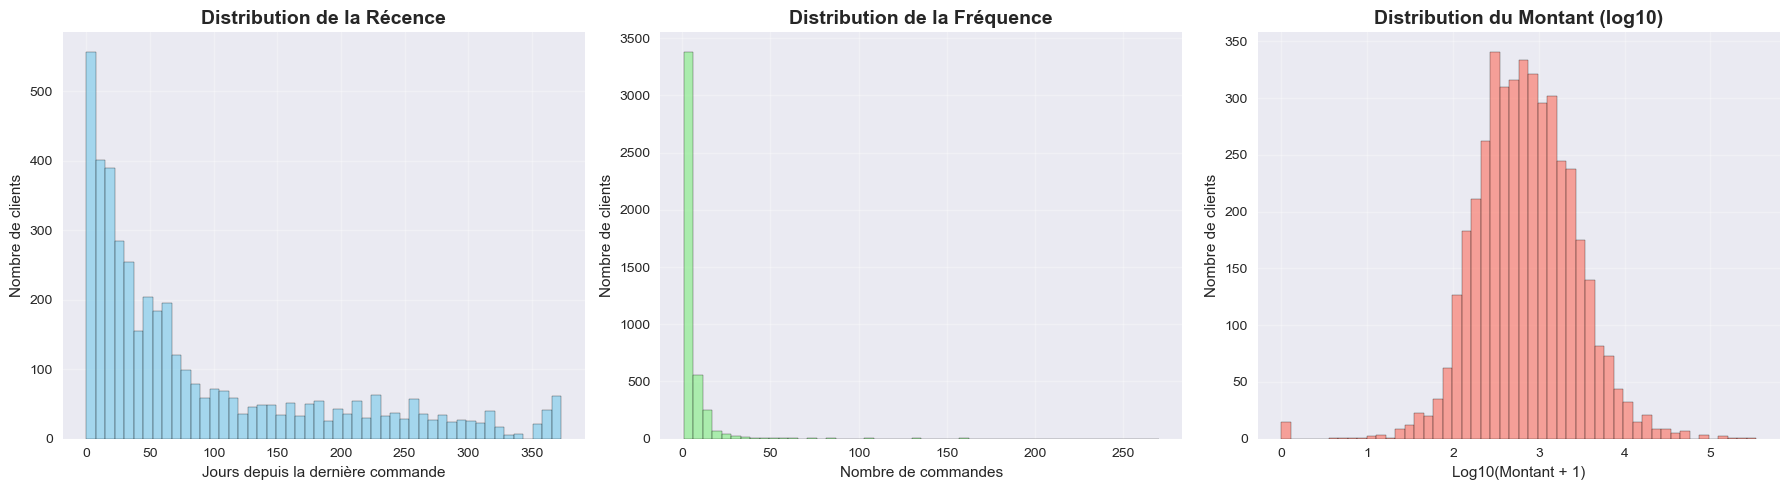


 MATRICE DE CORRÉLATION RFM:
           Recency  Frequency  Monetary
Recency      1.000     -0.251    -0.128
Frequency   -0.251      1.000     0.634
Monetary    -0.128      0.634     1.000


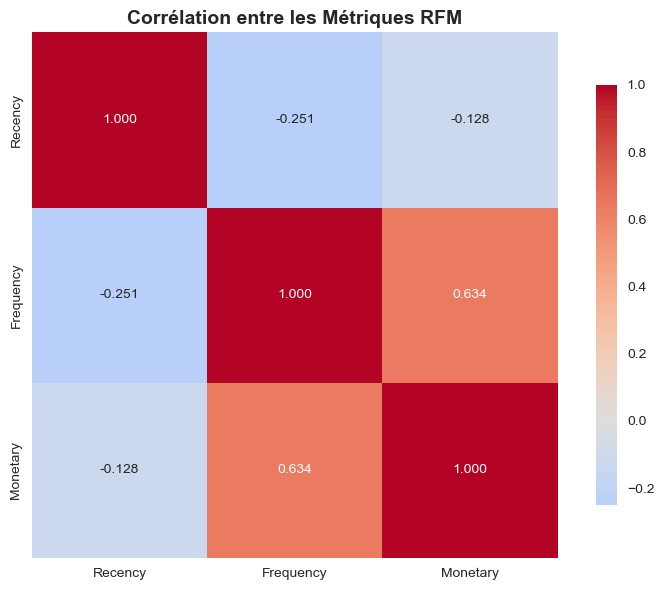

In [7]:
# Visualisation des Distributions RFM

print(" VISUALISATION DES DISTRIBUTIONS RFM")
print("="*40)

# Créer une figure avec 3 sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Distribution de la Récence
# On regarde combien de jours se sont écoulés depuis la dernière commande pour chaque client.
axes[0].hist(rfm_metrics['Recency'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution de la Récence', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Jours depuis la dernière commande')
axes[0].set_ylabel('Nombre de clients')
axes[0].grid(True, alpha=0.3)

# 2. Distribution de la Fréquence
axes[1].hist(rfm_metrics['Frequency'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title('Distribution de la Fréquence', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Nombre de commandes')
axes[1].set_ylabel('Nombre de clients')
axes[1].grid(True, alpha=0.3)

# 3. Distribution du Montant (avec échelle log pour mieux voir)
#Parce que les montants sont très inégaux (gros acheteurs vs tout petits). 
axes[2].hist(np.log10(rfm_metrics['Monetary'] + 1), bins=50, alpha=0.7, color='salmon', edgecolor='black')
axes[2].set_title('Distribution du Montant (log10)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Log10(Montant + 1)')
axes[2].set_ylabel('Nombre de clients')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Matrice de corrélation RFM
# On calcule comment chaque paire de variables R, F, M bouge ensemble.
print("\n MATRICE DE CORRÉLATION RFM:")
correlation_matrix = rfm_metrics.corr()
print(correlation_matrix.round(3))

# Heatmap de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Corrélation entre les Métriques RFM', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


INTERPRETATION RECENCE:
- Beaucoup de clients ont une récence faible (donc sont revenus récemment).
- Puis ça s’étale très loin vers la droite (= clients qui n’ont rien acheté depuis longtemps).
- Conclusion business : tu as beaucoup de clients “actifs récents”, et une longue traîne de clients dormants/inactifs.

 Interprétation : plus la récence est basse, meilleur est le client (récence = fidélité actuelle).

INTERPRETATION FREQUENCE:
- C’est extrêmement asymétrique : ÉNORMÉMENT de clients ont commandé très peu de fois.
- Quelques clients ont commandé des dizaines / centaines de fois (la “queue” à droite).
- C’est typique e-commerce : beaucoup d’acheteurs occasionnels, peu de clients très fidèles.

 Interprétation : les “bons clients” sont rares mais puissants.

INTERPRETATION MONTANT:
- Après transformation log, la distribution devient plus “belle”.
Ça veut dire que dépenser beaucoup vs peu varie sur plusieurs ordres de grandeur (x10, x100).

 Interprétation : Certains clients achètent énormément, beaucoup achètent peu — et la différence est énorme en valeur.

INTERPRETATION DE CORRELATION :

a) Recency vs Frequency = -0.251 (Corrélation négative)
- Plus un client commande souvent (haute fréquence), Plus sa récence est faible (il est venu récemment).
- Logique : les bons clients reviennent souvent et récemment.
=> bon signe de fidélité.

b) Frequency vs Monetary = 0.634 (Corrélation positive forte)
- Les clients qui commandent souvent dépensent plus au total, ca veut dire que la valeur financière vient clairement des clients récurrents.
=> ce sont tes “clients VIP”.

c) Recency vs Monetary = -0.128 (Corrélation légèrement négative)
- Les gens qui ont dépensé beaucoup ont tendance à être revenus plus récemment, mais ce n’est pas super fort.
Logique : on a des gros clients qui ne sont pas forcément récents (donc peut-être en train de churn).
=> à relancer en marketing.

In [8]:
# Scoring RFM et Segmentation

print(" SCORING RFM ET SEGMENTATION")
print("="*35)

# Cette partie transforme les trois valeurs R, F et M (récence, fréquence, montant) en scores normalisés (de 1 à 5).
# Puis on attribue à chaque client un segment marketing (ex: “Champion”, “À Risque”, etc.).
# C’est ce qui permet de classer tes clients selon leur comportement.

# Calcul des scores RFM (1-5) basés sur les quantiles
print(" 1) Calcul des scores RFM (1-5)...")

# Récence : plus récent = meilleur score (inversé)
# On inverse les scores R car plus la récence est basse, meilleur est le client.
rfm_scores = rfm_metrics.copy()
rfm_scores['R_Score'] = pd.qcut(rfm_metrics['Recency'].rank(method='first'), 5, labels=[5,4,3,2,1]).astype(int)

# Fréquence : plus fréquent = meilleur score
rfm_scores['F_Score'] = pd.qcut(rfm_metrics['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

# Monetary : plus élevé = meilleur score
rfm_scores['M_Score'] = pd.qcut(rfm_metrics['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

# Score RF combiné
rfm_scores['RF_Score'] = rfm_scores['R_Score'].astype(str) + rfm_scores['F_Score'].astype(str)
rfm_scores['RFM_Sum'] = rfm_scores[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

print(" Scores RFM calculés avec succès!")

# Segmentation basée sur les scores RF
print("\n 2) Segmentation des clients...")

def assign_segment(row):
    """Assigner un segment basé sur les scores R et F"""
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    if r >= 4 and f >= 4:
        return 'Champions'
    elif r >= 4 and 2 <= f <= 3:
        return 'Fidèles Récents'
    elif r >= 4 and f <= 2:
        return 'Prometteurs'
    elif 2 <= r <= 3 and f >= 4:
        return 'Fidèles'
    elif 2 <= r <= 3 and 2 <= f <= 3:
        return 'Standards'
    elif f >= 4 and r <= 2:
        return 'À Relancer'
    elif r <= 2 and f <= 2 and m >= 4:
        return 'Gros Dépensiers à Risque'
    elif r <= 2 and f <= 2:
        return 'À Risque'
    else:
        return 'Autres'

rfm_scores['Segment'] = rfm_scores.apply(assign_segment, axis=1)

# Statistiques des segments
print("\n RÉPARTITION DES SEGMENTS:")
segment_counts = rfm_scores['Segment'].value_counts()
segment_pct = (segment_counts / len(rfm_scores) * 100).round(2)

segment_summary = pd.DataFrame({
    'Nombre': segment_counts,
    'Pourcentage': segment_pct
})
print(segment_summary)

# Aperçu des scores RFM
print("\n APERÇU DES SCORES RFM:")
print(rfm_scores[['R_Score', 'F_Score', 'M_Score', 'RF_Score', 'RFM_Sum', 'Segment']].head(10))


 SCORING RFM ET SEGMENTATION
 1) Calcul des scores RFM (1-5)...
 Scores RFM calculés avec succès!

 2) Segmentation des clients...

 RÉPARTITION DES SEGMENTS:
                          Nombre  Pourcentage
Segment                                      
Champions                   1087        24.81
À Risque                     807        18.42
Standards                    789        18.01
Fidèles                      598        13.65
Fidèles Récents              529        12.07
Autres                       331         7.56
Prometteurs                  137         3.13
À Relancer                    67         1.53
Gros Dépensiers à Risque      36         0.82

 APERÇU DES SCORES RFM:
            R_Score  F_Score  M_Score RF_Score  RFM_Sum          Segment
CustomerID                                                              
12346.0           3        5        1       35        9          Fidèles
12347.0           5        2        4       52       11  Fidèles Récents
12348.0           

 VISUALISATION DES SEGMENTS RFM
 1)Heatmap RF (moyenne du montant)...


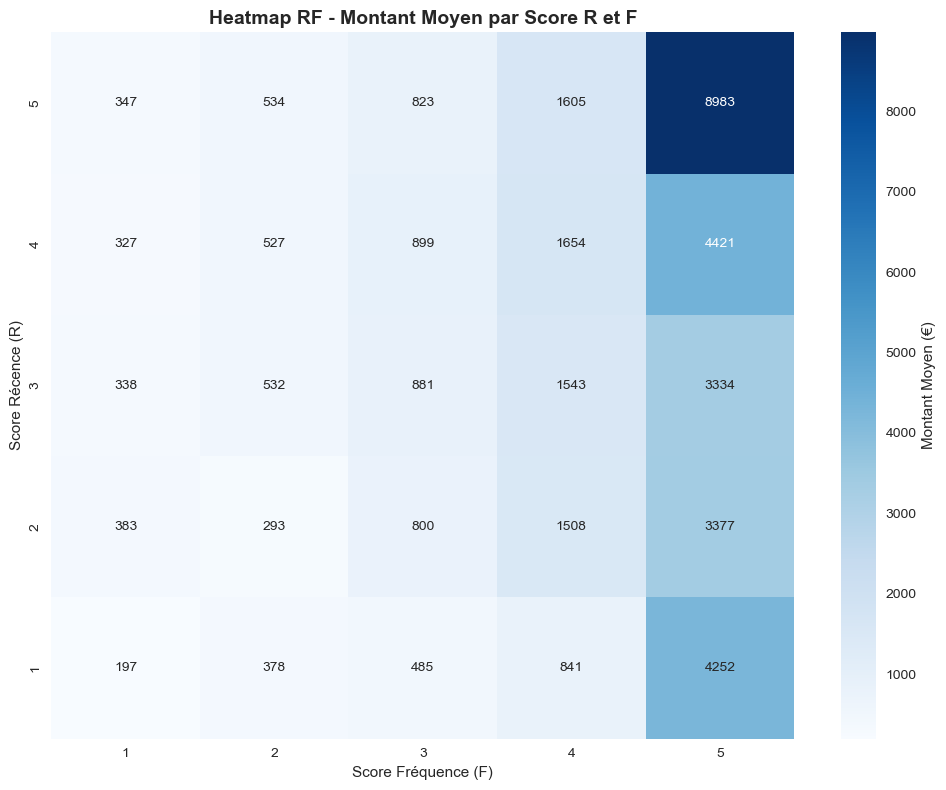


 2) Distribution des segments...


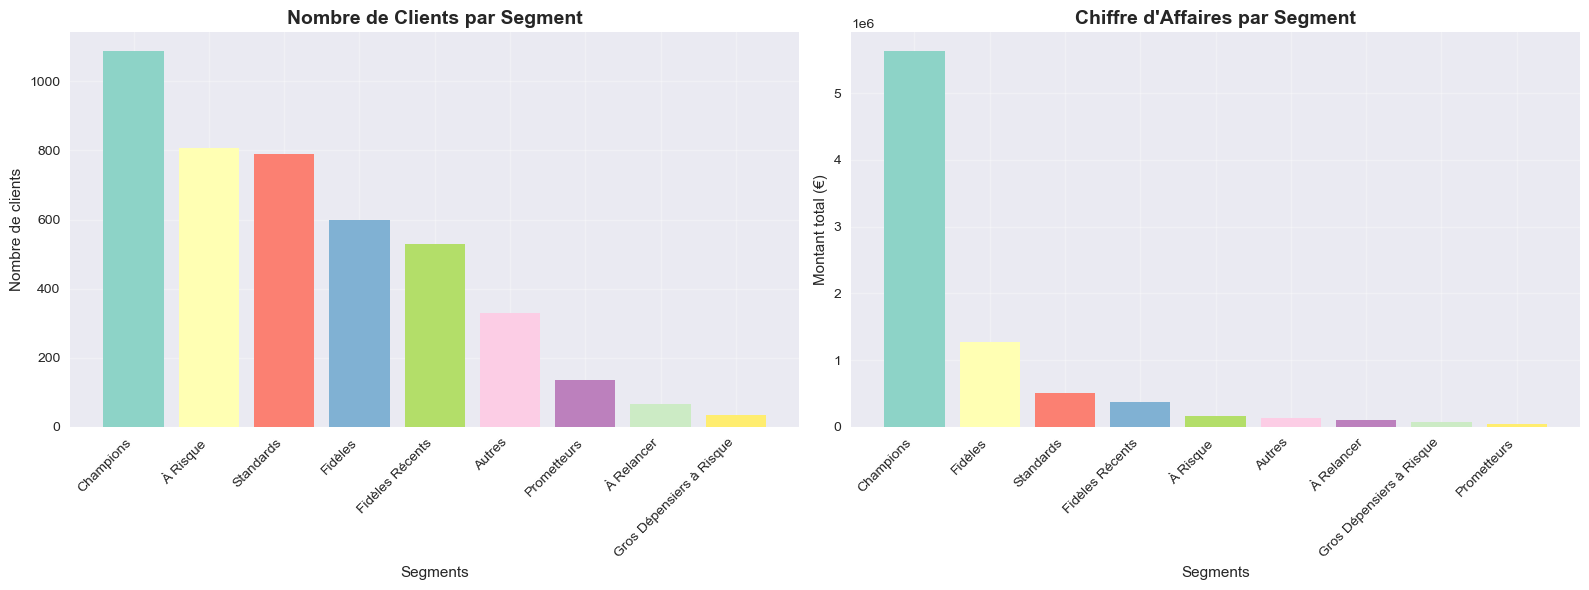


 3) Pairplot des scores RFM...


<Figure size 1200x1000 with 0 Axes>

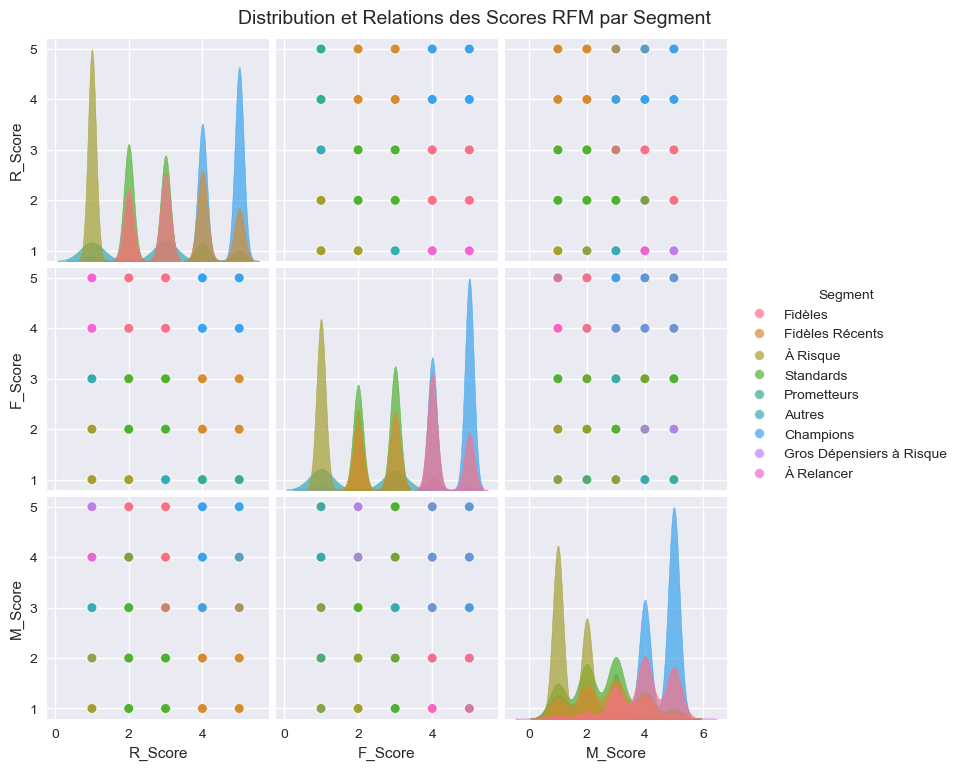

In [9]:
# Visualisation des Segments RFM

print(" VISUALISATION DES SEGMENTS RFM")
print("="*35)

# 1. Heatmap RF (moyenne du montant par R et F)
#axe vertical = score de récence (R) (5 = très récent),
#axe horizontal = score de fréquence (F) (5 = très fidèle)
#couleurs = montant moyen dépensé.

print(" 1)Heatmap RF (moyenne du montant)...")

rf_heatmap = rfm_scores.reset_index().pivot_table(
    index='R_Score', columns='F_Score', values='Monetary', aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(rf_heatmap.sort_index(ascending=False), annot=True, fmt='.0f', 
            cmap='Blues', cbar_kws={'label': 'Montant Moyen (€)'})
plt.title('Heatmap RF - Montant Moyen par Score R et F', fontsize=14, fontweight='bold')
plt.xlabel('Score Fréquence (F)')
plt.ylabel('Score Récence (R)')
plt.tight_layout()
plt.show()

# 2. Distribution des segments
print("\n 2) Distribution des segments...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Nombre de clients par segment
segment_counts = rfm_scores['Segment'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(segment_counts)))

axes[0].bar(range(len(segment_counts)), segment_counts.values, color=colors)
axes[0].set_title('Nombre de Clients par Segment', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Segments')
axes[0].set_ylabel('Nombre de clients')
axes[0].set_xticks(range(len(segment_counts)))
axes[0].set_xticklabels(segment_counts.index, rotation=45, ha='right')
axes[0].grid(True, alpha=0.3)

# Part du chiffre d'affaires par segment
segment_revenue = rfm_scores.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)
axes[1].bar(range(len(segment_revenue)), segment_revenue.values, color=colors)
axes[1].set_title('Chiffre d\'Affaires par Segment', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Segments')
axes[1].set_ylabel('Montant total (€)')
axes[1].set_xticks(range(len(segment_revenue)))
axes[1].set_xticklabels(segment_revenue.index, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Pairplot des scores RFM par segment

#Ce graphe montre Comment les segments se positionnent dans le “cube RFM”.
#Les diagonales indiquent la densité des scores par segment.
#Les points colorés montrent la séparation entre groupes.
print("\n 3) Pairplot des scores RFM...")

pairplot_data = rfm_scores.reset_index()
plt.figure(figsize=(12, 10))
sns.pairplot(pairplot_data, 
             vars=['R_Score', 'F_Score', 'M_Score'], 
             hue='Segment',
             diag_kind='kde',
             plot_kws={'alpha': 0.7, 's': 50},
             diag_kws={'alpha': 0.7})
plt.suptitle('Distribution et Relations des Scores RFM par Segment', y=1.02, fontsize=14)
plt.show()


Le pairplot montre la répartition des différents segments de clients dans l’espace des scores RFM. 

On observe que les Champions se concentrent dans les zones de scores élevés en récence, fréquence et montant, illustrant leur forte activité et leur grande valeur. 

À l’inverse, les segments À Risque et Gros Dépensiers à Risque se situent aux scores faibles de récence et de fréquence, traduisant une inactivité récente. 

Les autres segments, comme les Fidèles ou Prometteurs, occupent des positions intermédiaires. Cette visualisation confirme la bonne séparation entre les segments et la cohérence du modèle RFM.

# 4) Clustering : K-Means

K-Means est un algorithme de clustering **partitionnel** qui divise les données en k clusters sphériques.

###  Principe de Fonctionnement

1. **Initialisation** : Choisir k centroïdes aléatoirement
2. **Assignment** : Assigner chaque point au centroïde le plus proche
3. **Update** : Recalculer les centroïdes comme centre de gravité
4. **Répétition** : Répéter jusqu'à convergence



In [ ]:
# Préparation des Données pour le Clustering

print(" PRÉPARATION DES DONNÉES POUR LE CLUSTERING")
print("="*50)

# 1. Normalisation des données RFM
print(" Normalisation des données RFM...")

# Préparer les données pour le clustering
X_rfm = rfm_metrics[['Recency', 'Frequency', 'Monetary']].copy()

# Normalisation avec StandardScaler (moyenne=0, écart-type=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_rfm)

# Créer un DataFrame normalisé pour faciliter l'analyse
X_scaled_df = pd.DataFrame(X_scaled, 
                          columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'], 
                          index=X_rfm.index)

print(f"   Données normalisées: {X_scaled.shape}")
print(f"   Moyennes après normalisation: {X_scaled_df.mean().round(6).to_dict()}")
print(f"   Écart-types après normalisation: {X_scaled_df.std().round(6).to_dict()}")

# Vérification de la normalisation
print("\n Vérification de la normalisation:")
print("   - Moyennes ≈ 0 :", np.allclose(X_scaled_df.mean(), 0, atol=1e-10))
print("   - Écart-types ≈ 1 :", np.allclose(X_scaled_df.std(), 1, atol=1e-10))

# Aperçu des données normalisées
print(f"\n Aperçu des données normalisées:")
print(X_scaled_df.head())


 PRÉPARATION DES DONNÉES POUR LE CLUSTERING
 Normalisation des données RFM...
   Données normalisées: (4381, 3)
   Moyennes après normalisation: {'Recency_scaled': 0.0, 'Frequency_scaled': 0.0, 'Monetary_scaled': -0.0}
   Écart-types après normalisation: {'Recency_scaled': 1.000114, 'Frequency_scaled': 1.000114, 'Monetary_scaled': 1.000114}

 Vérification de la normalisation:
   - Moyennes ≈ 0 : True
   - Écart-types ≈ 1 : False

 Aperçu des données normalisées:
            Recency_scaled  Frequency_scaled  Monetary_scaled
CustomerID                                                   
12346.0          -0.247738          0.956618        -0.228894
12347.0          -0.900230         -0.336576        -0.067461
12348.0          -0.176371         -0.436052        -0.196738
12349.0          -0.492422         -0.137623         0.087940
12351.0          -0.818668         -0.436052        -0.187491


 MÉTHODE DU COUDE POUR DÉTERMINER K OPTIMAL
 Test de différentes valeurs de k...
   k=2: Inertie=8963.58, Silhouette=0.916
   k=3: Inertie=5354.10, Silhouette=0.590
   k=4: Inertie=3668.46, Silhouette=0.609
   k=5: Inertie=2855.00, Silhouette=0.603
   k=6: Inertie=2319.55, Silhouette=0.527
   k=7: Inertie=1896.85, Silhouette=0.502
   k=8: Inertie=1574.14, Silhouette=0.499
   k=9: Inertie=1407.85, Silhouette=0.427
   k=10: Inertie=1240.43, Silhouette=0.407


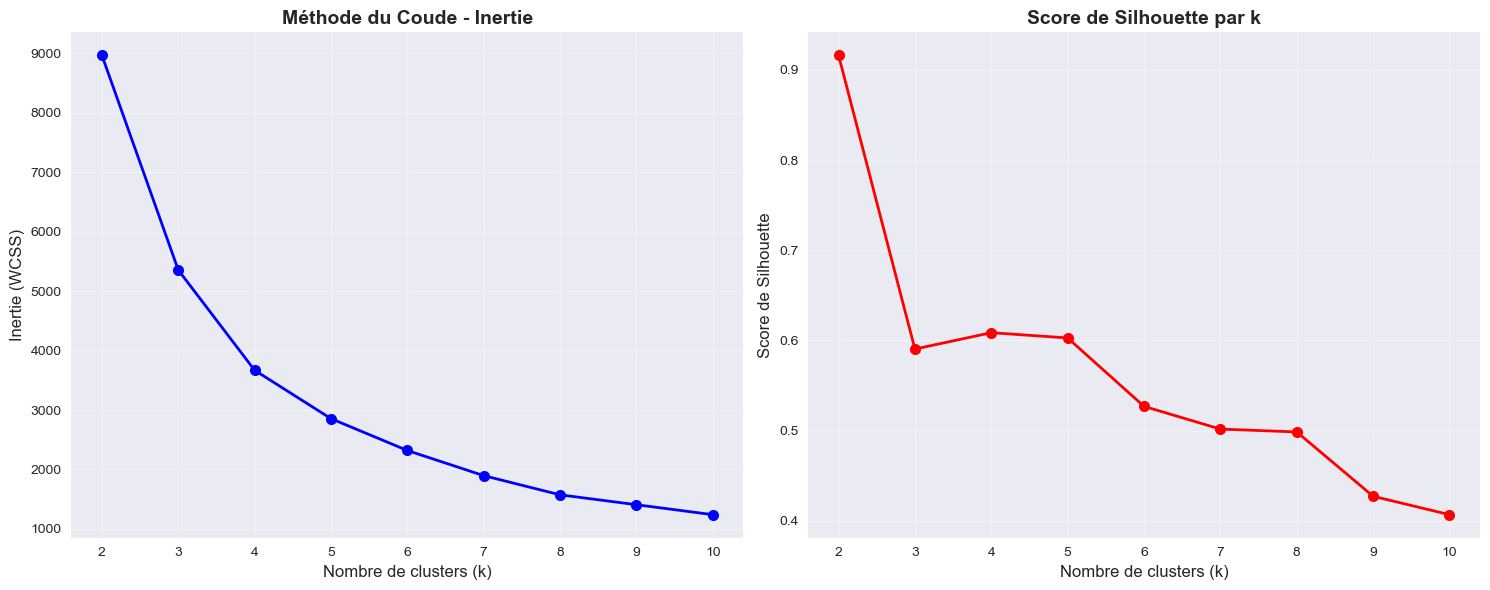


 K OPTIMAL:
   - Méthode du coude: k = 4
   - Score de silhouette max: k = 2
   - Score de silhouette max: 0.916

 K choisi: 4


In [11]:
# Méthode du Coude pour K-Means

print(" MÉTHODE DU COUDE POUR DÉTERMINER K OPTIMAL")
print("="*50)

# Tester différentes valeurs de k
k_range = range(2, 11)
inertias = []
silhouette_scores = []

print(" Test de différentes valeurs de k...")

for k in k_range:
    # K-Means avec k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    # Inertie (Within-cluster sum of squares)
    inertias.append(kmeans.inertia_)
    
    # Score de silhouette
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
    print(f"   k={k}: Inertie={kmeans.inertia_:.2f}, Silhouette={silhouette_score(X_scaled, kmeans.labels_):.3f}")

# Visualisation de la méthode du coude
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Graphique de l'inertie (méthode du coude)
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Nombre de clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertie (WCSS)', fontsize=12)
axes[0].set_title('Méthode du Coude - Inertie', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Graphique du score de silhouette
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Nombre de clusters (k)', fontsize=12)
axes[1].set_ylabel('Score de Silhouette', fontsize=12)
axes[1].set_title('Score de Silhouette par k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

plt.tight_layout()
plt.show()

# Déterminer le k optimal
optimal_k_inertia = 4  # Point de coude visible
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]

print(f"\n K OPTIMAL:")
print(f"   - Méthode du coude: k = {optimal_k_inertia}")
print(f"   - Score de silhouette max: k = {optimal_k_silhouette}")
print(f"   - Score de silhouette max: {max(silhouette_scores):.3f}")

# Choisir k=4 (compromis entre les deux méthodes)
optimal_k = 4
print(f"\n K choisi: {optimal_k}")


 K-MEANS FINAL AVEC K OPTIMAL
 K-Means appliqué avec k=4
 Distribution des clusters:
KMeans_Cluster
0      54
1    3249
2    1073
3       5
Name: count, dtype: int64

 STATISTIQUES PAR CLUSTER:
               Recency              Frequency                Monetary                
                  mean    std count      mean    std count       mean       std count
KMeans_Cluster                                                                       
0                 9.43  21.61    54     59.61  35.26    54   27489.94  18440.20    54
1                41.20  35.03  3249      5.43   5.27  3249    1650.18   2361.97  3249
2               243.45  66.54  1073      1.90   1.58  1073     404.73   1510.09  1073
3                 4.60   4.34     5    139.00  75.76     5  206935.30  88184.26     5

 VISUALISATION DES CLUSTERS (PCA):


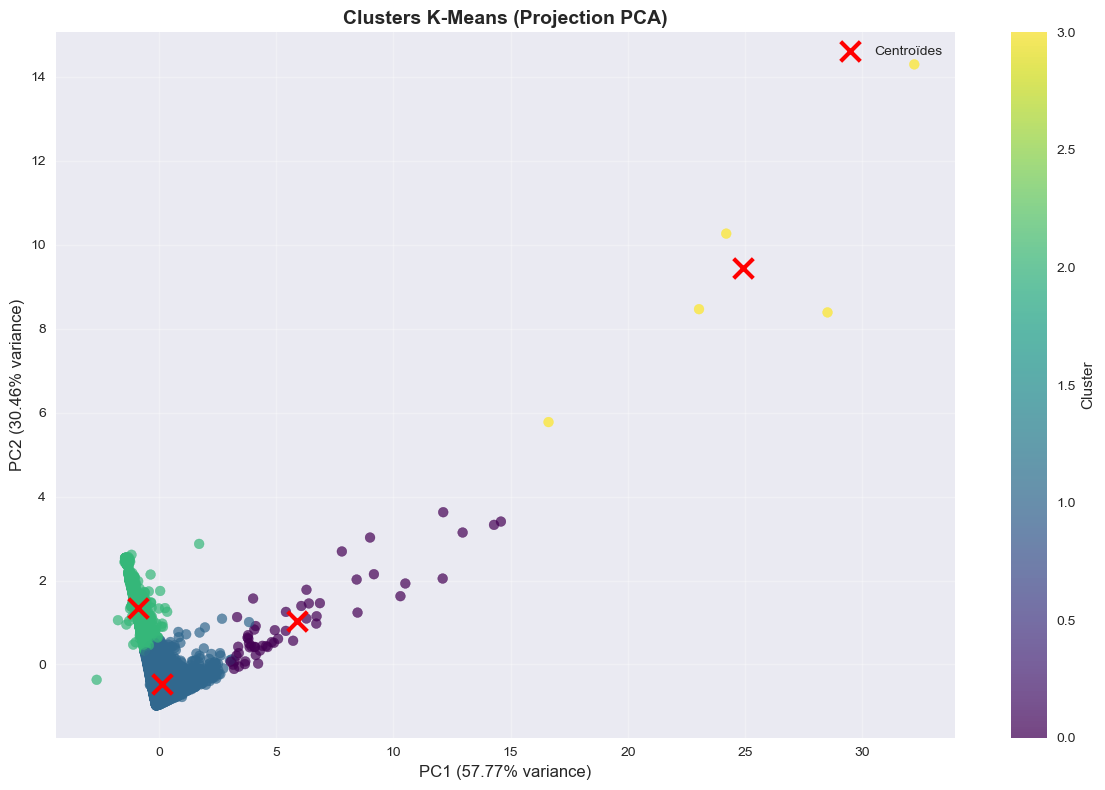

 Variance expliquée par les 2 premières composantes: 88.23%

 MÉTRIQUES D'ÉVALUATION K-MEANS:
   - Score de Silhouette: 0.609
   - Score de Calinski-Harabasz: 3768.16
   - Score de Davies-Bouldin: 0.607


In [12]:
# K-Means Final avec k Optimal

print(" K-MEANS FINAL AVEC K OPTIMAL")
print("="*35)

# K-Means avec k optimal
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Ajouter les labels au DataFrame RFM
rfm_with_clusters = rfm_metrics.copy()
rfm_with_clusters['KMeans_Cluster'] = kmeans_labels

print(f" K-Means appliqué avec k={optimal_k}")
print(f" Distribution des clusters:")
cluster_distribution = rfm_with_clusters['KMeans_Cluster'].value_counts().sort_index()
print(cluster_distribution)

# Statistiques par cluster
print(f"\n STATISTIQUES PAR CLUSTER:")
cluster_stats = rfm_with_clusters.groupby('KMeans_Cluster')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'std', 'count'])
print(cluster_stats.round(2))

# Visualisation des clusters avec PCA
print(f"\n VISUALISATION DES CLUSTERS (PCA):")

# PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Créer la visualisation
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('Clusters K-Means (Projection PCA)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Ajouter les centroïdes
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x', s=200, linewidths=3, label='Centroïdes')
plt.legend()
plt.tight_layout()
plt.show()

print(f" Variance expliquée par les 2 premières composantes: {pca.explained_variance_ratio_.sum():.2%}")

# Métriques d'évaluation
silhouette_kmeans = silhouette_score(X_scaled, kmeans_labels)
calinski_kmeans = calinski_harabasz_score(X_scaled, kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"\n MÉTRIQUES D'ÉVALUATION K-MEANS:")
print(f"   - Score de Silhouette: {silhouette_kmeans:.3f}")
print(f"   - Score de Calinski-Harabasz: {calinski_kmeans:.2f}")
print(f"   - Score de Davies-Bouldin: {davies_bouldin_kmeans:.3f}")


Le graphique PCA montre que les clients se répartissent en quatre groupes bien distincts :

- un grand ensemble de clients moyens/actifs (dominant),
- un groupe de clients fidèles légèrement différent,
- un groupe de clients dormants plus dispersés,
- un petit groupe VIP très éloigné du reste, représentant les clients les plus précieux.

Cette séparation nette confirme la pertinence du modèle K-Means, puisque les clusters sont visuellement bien différenciés et les centroïdes isolés les uns des autres.

Trois métriques d’évaluation confirment la bonne qualité du modèle K-Means :

- Silhouette (0.609) : bonne séparation et cohésion des clusters, indiquant une structure bien définie.

- Calinski–Harabasz (3768.16) : forte variance inter-cluster et faible variance intra-cluster, preuve de la compacité et de la distinction des groupes.

- Davies–Bouldin (0.607) : faible similarité entre clusters, signalant peu de chevauchement.

Ces résultats montrent que la segmentation K-Means avec k=4 est cohérente, stable et exploitable pour identifier des profils de clients distincts.

# 5) Clustering : DBSCAN

DBSCAN est un algorithme de clustering basé sur la densité.
- Il regroupe les points à haute densité.
- Il détecte automatiquement le nombre de clusters.
- Il marque les points isolés comme du bruit (`-1`).

### Paramètres clés
- `eps` : distance maximale entre deux points pour être voisins.
- `min_samples` : nombre minimum de points pour former une région dense.



 SÉLECTION DE EPS POUR DBSCAN (k-distance plot)


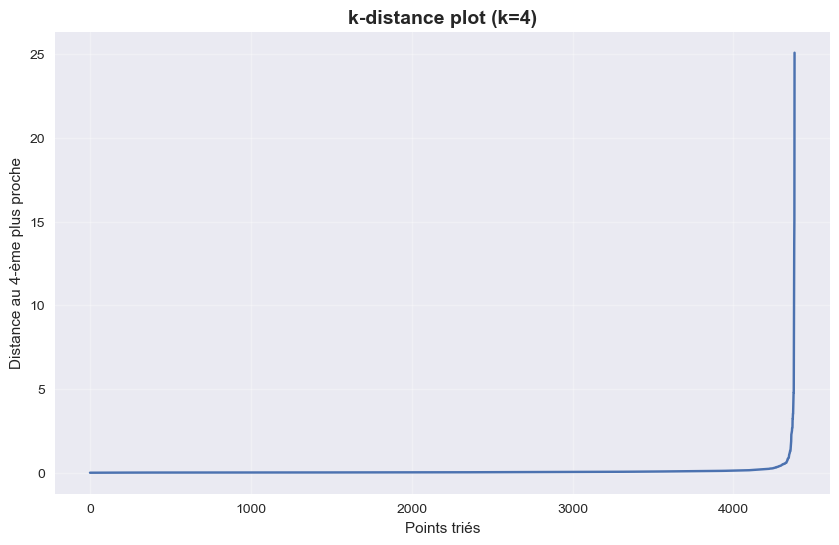

Paramètres DBSCAN choisis: eps=0.5, min_samples=4
Nombre de clusters DBSCAN: 2
Points de bruit: 60 (1.37%)
Distribution des labels:
-1      60
 0    4312
 1       9
Name: count, dtype: int64


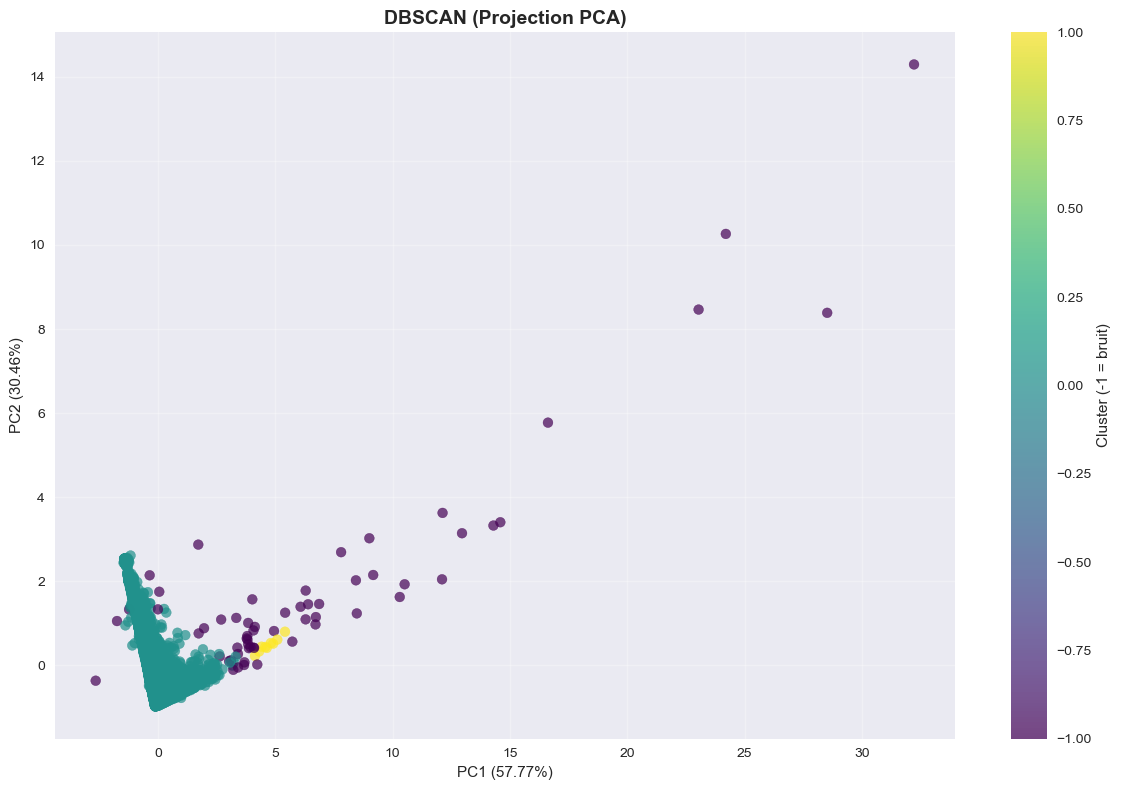


 MÉTRIQUES DBSCAN (sans bruit):
   - Silhouette: 0.7486851247375772
   - Calinski-Harabasz: 190.03733752371986
   - Davies-Bouldin: 0.25909975409629254


In [13]:
# Sélection du paramètre eps (k-distance plot)

print(" SÉLECTION DE EPS POUR DBSCAN (k-distance plot)")

k = 4  # règle pratique: ~ dimension + 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Trier les distances de la k-ième plus proche
k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title('k-distance plot (k=4)', fontsize=14, fontweight='bold')
plt.xlabel('Points triés')
plt.ylabel(f'Distance au {k}-ème plus proche')
plt.grid(True, alpha=0.3)
plt.show()

# Choisir un eps par défaut (à ajuster selon le coude du graphique)
eps = 0.5
min_samples = k
print(f"Paramètres DBSCAN choisis: eps={eps}, min_samples={min_samples}")

# DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Résultats DBSCAN
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Nombre de clusters DBSCAN: {n_clusters_dbscan}")
print(f"Points de bruit: {n_noise} ({n_noise/len(dbscan_labels):.2%})")
print("Distribution des labels:")
print(pd.Series(dbscan_labels).value_counts().sort_index())

# Visualisation PCA
pca_db = PCA(n_components=2)
X_pca_db = pca_db.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca_db[:, 0], X_pca_db[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='Cluster (-1 = bruit)')
plt.title('DBSCAN (Projection PCA)', fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca_db.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_db.explained_variance_ratio_[1]:.2%})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Métriques DBSCAN (en excluant le bruit pour certaines métriques)
mask_core = dbscan_labels != -1
if mask_core.sum() > 0 and len(np.unique(dbscan_labels[mask_core])) > 1:
    silhouette_db = silhouette_score(X_scaled[mask_core], dbscan_labels[mask_core])
    calinski_db = calinski_harabasz_score(X_scaled[mask_core], dbscan_labels[mask_core])
    davies_db = davies_bouldin_score(X_scaled[mask_core], dbscan_labels[mask_core])
else:
    silhouette_db = np.nan
    calinski_db = np.nan
    davies_db = np.nan

print("\n MÉTRIQUES DBSCAN (sans bruit):")
print(f"   - Silhouette: {silhouette_db}")
print(f"   - Calinski-Harabasz: {calinski_db}")
print(f"   - Davies-Bouldin: {davies_db}")


DBSCAN ne cherche pas à mettre tout le monde dans un cluster, contrairement à K-Means.
Il cherche juste les “zones de densité”. Tout ce qui reste tout seul → bruit.

- Le k-distance plot sert à choisir eps en regardant à partir de quelle distance les points deviennent isolés. Ça permet de dire à DBSCAN ce qu’est une “zone dense”.

- DBSCAN ne force pas tous les clients dans un cluster.
Il détecte des régions denses (comportements typiques et cohérents),
et marque le reste comme bruit / anomalies locales (-1).

- La visualisation PCA montre bien :gros cluster dense, plusieurs petits clusters,
et plein de points isolés que K-Means aurait rangés quand même,
mais que DBSCAN refuse de ranger.

- Les métriques (silhouette = 0.75, Davies-Bouldin = 0.26) disent que
les clusters que DBSCAN accepte sont très propres et bien distincts.
Mais DBSCAN couvre moins de monde : il est plus sélectif.

# 6) Clustering : Gaussian Mixtures (GMM)

Le modèle de mélanges gaussiens (GMM) suppose que les données proviennent d'un mélange de distributions normales.
- Chaque cluster est modélisé par une gaussienne
- Permet des clusters elliptiques
- Fournit des probabilités d'appartenance aux clusters



 SÉLECTION DU NOMBRE DE COMPOSANTS (BIC/AIC) POUR GMM


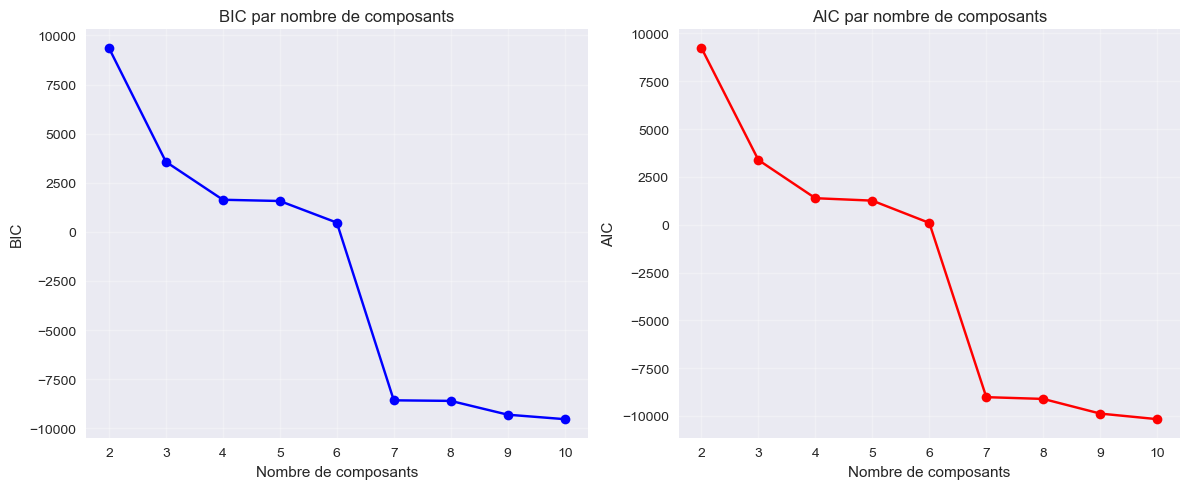

 Nombre optimal de composants (BIC): 10
Distribution des clusters GMM:
0     808
1     539
2       3
3     318
4      64
5       2
6     721
7      99
8    1216
9     611
Name: count, dtype: int64


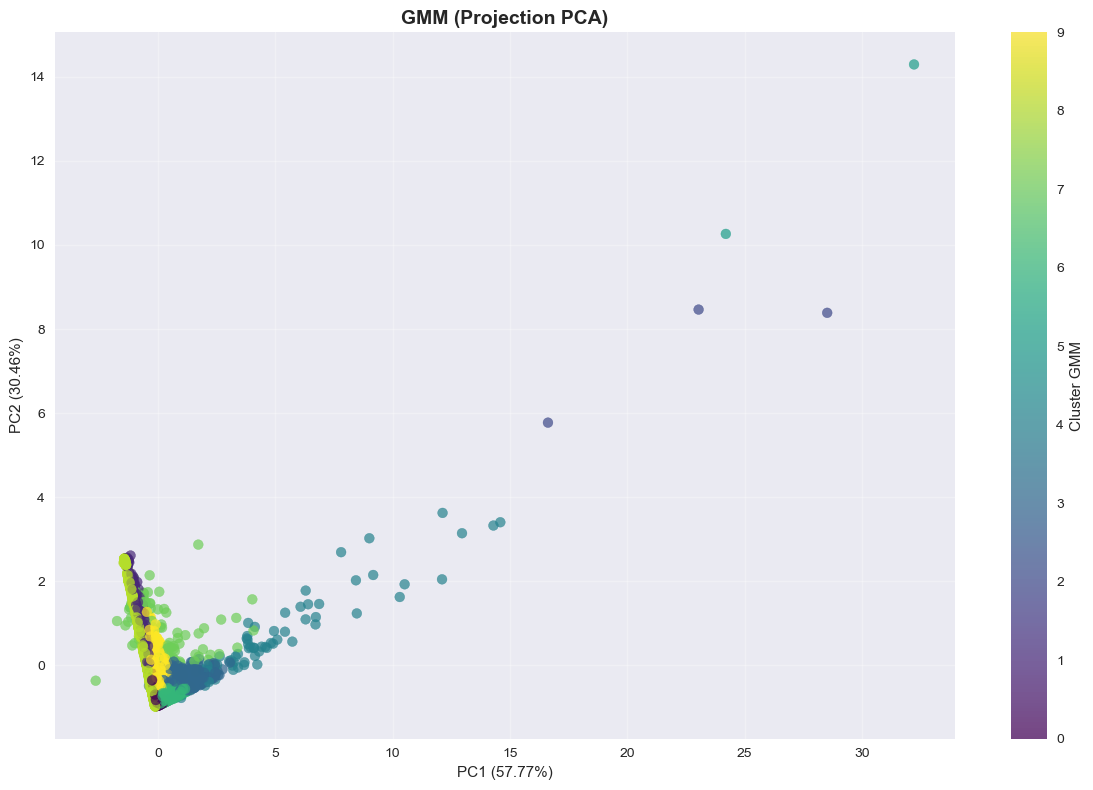


 MÉTRIQUES GMM:
   - Silhouette: -0.014
   - Calinski-Harabasz: 1046.78
   - Davies-Bouldin: 1.995


In [ ]:
# Sélection du nombre de composants (BIC/AIC)

print(" SÉLECTION DU NOMBRE DE COMPOSANTS (BIC/AIC) POUR GMM")

n_components_range = range(2, 11)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm_tmp = GaussianMixture(n_components=n, random_state=42)
    gmm_tmp.fit(X_scaled)
    bic_scores.append(gmm_tmp.bic(X_scaled))
    aic_scores.append(gmm_tmp.aic(X_scaled))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic_scores, 'bo-', label='BIC')
plt.xlabel('Nombre de composants')
plt.ylabel('BIC')
plt.title('BIC par nombre de composants')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(n_components_range, aic_scores, 'ro-', label='AIC')
plt.xlabel('Nombre de composants')
plt.ylabel('AIC')
plt.title('AIC par nombre de composants')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

optimal_components = n_components_range[np.argmin(bic_scores)]
print(f" Nombre optimal de composants (BIC): {optimal_components}")

# GMM final
gmm_final = GaussianMixture(n_components=optimal_components, random_state=42)
gmm_labels = gmm_final.fit_predict(X_scaled)

# Ajouter au DataFrame
rfm_with_clusters['GMM_Cluster'] = gmm_labels

print("Distribution des clusters GMM:")
print(pd.Series(gmm_labels).value_counts().sort_index())

# Visualisation PCA
pca_gmm = PCA(n_components=2)
X_pca_gmm = pca_gmm.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca_gmm[:, 0], X_pca_gmm[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='Cluster GMM')
plt.title('GMM (Projection PCA)', fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca_gmm.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_gmm.explained_variance_ratio_[1]:.2%})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Métriques GMM
silhouette_gmm = silhouette_score(X_scaled, gmm_labels)
calinski_gmm = calinski_harabasz_score(X_scaled, gmm_labels)
davies_bouldin_gmm = davies_bouldin_score(X_scaled, gmm_labels)

print("\n MÉTRIQUES GMM:")
print(f"   - Silhouette: {silhouette_gmm:.3f}")
print(f"   - Calinski-Harabasz: {calinski_gmm:.2f}")
print(f"   - Davies-Bouldin: {davies_bouldin_gmm:.3f}")


- Le modèle GMM produit 10 groupes, dont certains extrêmement petits (2 ou 3 clients). La projection PCA montre que ces groupes se recouvrent fortement dans l’espace RFM : plusieurs clusters apparaissent dans la même zone.
- Les métriques globales sont mauvaises par rapport à K-Means et DBSCAN : Cela signifie que, même si GMM décrit bien statistiquement la distribution des données (BIC faible), il ne fournit pas des segments nets, bien séparés et interprétables.

# 7) Comparaison et Interprétation des Algorithmes

##  Objectif
Comparer K-Means, DBSCAN et GMM selon des métriques internes et la lisibilité des clusters, puis interpréter les segments RFM associés.

##  Métriques internes utilisées
- **Silhouette** (plus haut = mieux)
- **Calinski-Harabasz** (plus haut = mieux)
- **Davies-Bouldin** (plus bas = mieux)


 COMPARAISON DES ALGORITHMES:
            Algorithme  Silhouette  Calinski-Harabasz  Davies-Bouldin
0              K-Means      0.6087          3768.1603          0.6071
1  DBSCAN (sans bruit)      0.7487           190.0373          0.2591
2                  GMM     -0.0136          1046.7799          1.9948


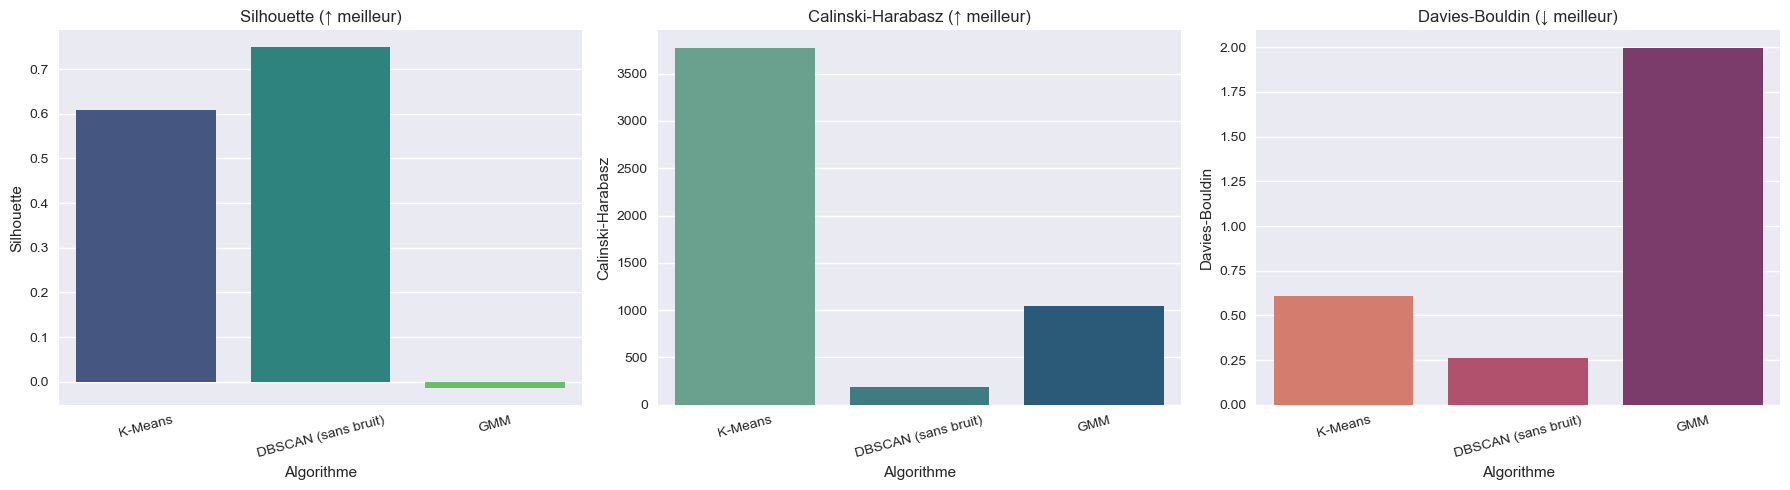


 Meilleurs algorithmes par métrique:
- Silhouette: DBSCAN (sans bruit)
- Calinski-Harabasz: K-Means
- Davies-Bouldin: DBSCAN (sans bruit)


In [34]:
# Tableau comparatif des algorithmes (métriques internes)

comparison = pd.DataFrame({
    'Algorithme': ['K-Means', 'DBSCAN (sans bruit)', 'GMM'],
    'Silhouette': [silhouette_kmeans, silhouette_db, silhouette_gmm],
    'Calinski-Harabasz': [calinski_kmeans, calinski_db, calinski_gmm],
    'Davies-Bouldin': [davies_bouldin_kmeans, davies_db, davies_bouldin_gmm]
})

# Afficher la table
print(" COMPARAISON DES ALGORITHMES:")
print(comparison.round(4))

# Visualiser comparaison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(data=comparison, x='Algorithme', y='Silhouette', ax=axes[0], palette='viridis')
axes[0].set_title('Silhouette (↑ meilleur)')
axes[0].tick_params(axis='x', rotation=15)

sns.barplot(data=comparison, x='Algorithme', y='Calinski-Harabasz', ax=axes[1], palette='crest')
axes[1].set_title('Calinski-Harabasz (↑ meilleur)')
axes[1].tick_params(axis='x', rotation=15)

sns.barplot(data=comparison, x='Algorithme', y='Davies-Bouldin', ax=axes[2], palette='flare')
axes[2].set_title('Davies-Bouldin (↓ meilleur)')
axes[2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

# Interprétation rapide
best_silhouette = comparison.loc[comparison['Silhouette'].idxmax(), 'Algorithme']
best_calinski = comparison.loc[comparison['Calinski-Harabasz'].idxmax(), 'Algorithme']
best_davies = comparison.loc[comparison['Davies-Bouldin'].idxmin(), 'Algorithme']

print("\n Meilleurs algorithmes par métrique:")
print(f"- Silhouette: {best_silhouette}")
print(f"- Calinski-Harabasz: {best_calinski}")
print(f"- Davies-Bouldin: {best_davies}")


# 8) Métriques (externes) et Alignement avec RFM

Nous comparons les clusters obtenus aux segments RFM (pseudo ground-truth) en mappant les labels via l’algorithme Hongrois.

- **ARI** (Adjusted Rand Index) — accord corrigé du hasard
- **NMI** (Normalized Mutual Information) — information partagée normalisée
- **F1** (macro et pondéré) — via la meilleure correspondance de labels


 MÉTRIQUES EXTERNES (alignées sur RFM):
      Algo     ARI     NMI  F1_macro  F1_weighted     n
0  K-Means  0.1326  0.2624    0.1344       0.2527  4381
1  DBSCAN* -0.0007  0.0031    0.0428       0.0927  4321
2      GMM  0.3532  0.4618    0.3280       0.5330  4381


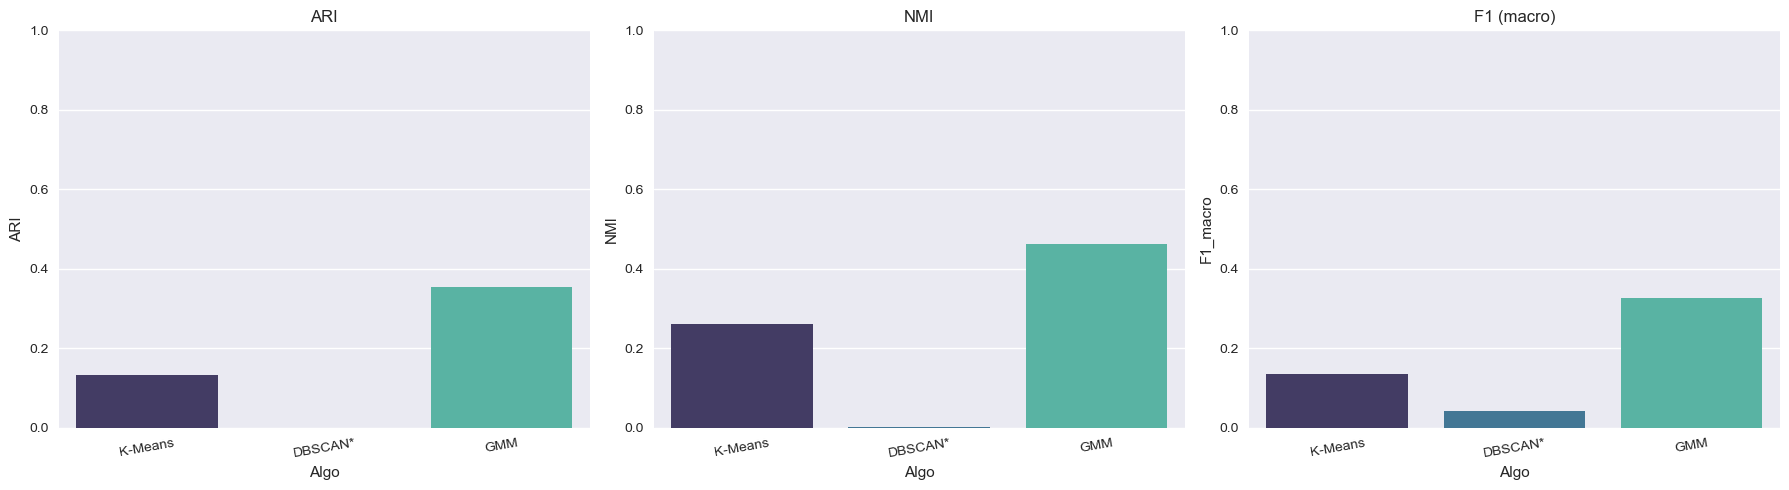

In [17]:
# Alignement des labels et calcul des métriques externes

# Ground truth heuristique basé sur RFM
true_labels = rfm_scores['Segment'].reindex(rfm_with_clusters.index)

# Fonction de mapping optimal (Hungarian)
def best_map(true_series, pred_labels):
    true_unique = {v: i for i, v in enumerate(true_series.unique())}
    y_true = true_series.map(true_unique).values
    y_pred = pred_labels
    D = pd.crosstab(y_true, y_pred).values
    r_ind, c_ind = linear_sum_assignment(D.max() - D)
    mapping = {c: r for r, c in zip(r_ind, c_ind)}
    y_pred_mapped = np.array([mapping.get(p, -1) for p in y_pred])
    return y_true, y_pred_mapped

metrics_rows = []

# K-Means
y_true_km, y_pred_km = best_map(true_labels, kmeans_labels)
metrics_rows.append({
    'Algo': 'K-Means',
    'ARI': adjusted_rand_score(y_true_km, y_pred_km),
    'NMI': normalized_mutual_info_score(y_true_km, y_pred_km),
    'F1_macro': f1_score(y_true_km, y_pred_km, average='macro'),
    'F1_weighted': f1_score(y_true_km, y_pred_km, average='weighted'),
    'n': len(y_true_km)
})

# DBSCAN (exclure le bruit)
mask_db = dbscan_labels != -1
y_true_db, y_pred_db = best_map(true_labels[mask_db], dbscan_labels[mask_db])
if len(np.unique(y_pred_db)) > 1:
    metrics_rows.append({
        'Algo': 'DBSCAN*',
        'ARI': adjusted_rand_score(y_true_db, y_pred_db),
        'NMI': normalized_mutual_info_score(y_true_db, y_pred_db),
        'F1_macro': f1_score(y_true_db, y_pred_db, average='macro'),
        'F1_weighted': f1_score(y_true_db, y_pred_db, average='weighted'),
        'n': len(y_true_db)
    })
else:
    metrics_rows.append({'Algo':'DBSCAN*','ARI':np.nan,'NMI':np.nan,'F1_macro':np.nan,'F1_weighted':np.nan,'n':mask_db.sum()})

# GMM
y_true_gmm, y_pred_gmm = best_map(true_labels, gmm_labels)
metrics_rows.append({
    'Algo': 'GMM',
    'ARI': adjusted_rand_score(y_true_gmm, y_pred_gmm),
    'NMI': normalized_mutual_info_score(y_true_gmm, y_pred_gmm),
    'F1_macro': f1_score(y_true_gmm, y_pred_gmm, average='macro'),
    'F1_weighted': f1_score(y_true_gmm, y_pred_gmm, average='weighted'),
    'n': len(y_true_gmm)
})

metrics_ext = pd.DataFrame(metrics_rows)
print(' MÉTRIQUES EXTERNES (alignées sur RFM):')
print(metrics_ext.round(4))

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, col, title in zip(axes, ['ARI','NMI','F1_macro'], ['ARI','NMI','F1 (macro)']):
    sns.barplot(data=metrics_ext, x='Algo', y=col, ax=ax, palette='mako')
    ax.set_title(title)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=10)
plt.tight_layout()
plt.show()


# 9) Détection d'Anomalies

Nous détectons des transactions anormales (erreurs, retours anormaux, paniers atypiques) avec Isolation Forest.

- Inclut les transactions sans `CustomerID` (ne pas les supprimer)
- Visualise les anomalies en 2D via PCA


 DÉTECTION D'ANOMALIES AVEC ISOLATION FOREST
Total transactions: 514,915
Anomalies détectées: 41,182 (8.00%)


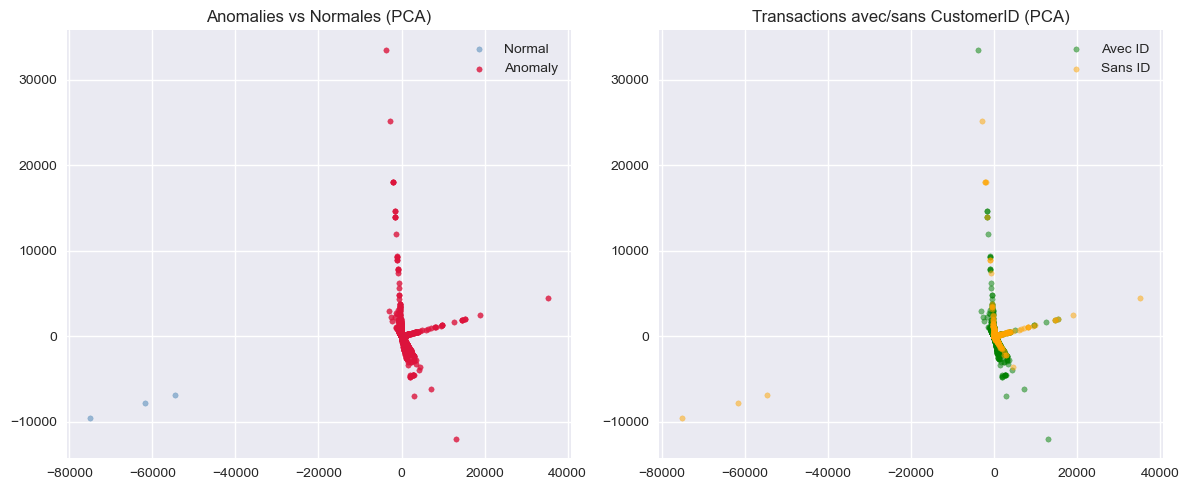


Exemples d'anomalies:
   Invoice StockCode                          Description  Quantity  Price  LineAmount  CustomerID  IsReturn
0   489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   6.95        83.4     13085.0     False
1   489434    79323P                   PINK CHERRY LIGHTS        12   6.75        81.0     13085.0     False
2   489434    79323W                  WHITE CHERRY LIGHTS        12   6.75        81.0     13085.0     False
3   489434     22041          RECORD FRAME 7" SINGLE SIZE        48   2.10       100.8     13085.0     False
61  489438    84031A    CHARLIE+LOLA RED HOT WATER BOTTLE        56   3.00       168.0     18102.0     False
62  489438    84031B   CHARLIE LOLA BLUE HOT WATER BOTTLE        56   3.00       168.0     18102.0     False
63  489438    84032A   CHARLIE+LOLA PINK HOT WATER BOTTLE        60   1.90       114.0     18102.0     False
64  489438    84032B  CHARLIE + LOLA RED HOT WATER BOTTLE        56   1.90       106.4     18102.0     Fa

In [18]:
# Isolation Forest pour anomalies

print(" DÉTECTION D'ANOMALIES AVEC ISOLATION FOREST")

anomaly_df = clean_df.copy()
anomaly_df['IsReturn'] = anomaly_df['Quantity'] < 0
anomaly_df['HasCustomerID'] = anomaly_df['CustomerID'].notna()
anomaly_df['Hour'] = anomaly_df['InvoiceDate'].dt.hour
anomaly_df['IsWeekend'] = anomaly_df['InvoiceDate'].dt.weekday >= 5

anomaly_features = ['Quantity', 'Price', 'LineAmount', 'IsReturn', 'HasCustomerID', 'Hour', 'IsWeekend']
X_anom = anomaly_df[anomaly_features].fillna(0)

iso = IsolationForest(contamination=0.08, random_state=42)
anom_labels = iso.fit_predict(X_anom)
anomaly_df['IsAnomaly'] = anom_labels == -1

print(f"Total transactions: {len(anomaly_df):,}")
print(f"Anomalies détectées: {anomaly_df['IsAnomaly'].sum():,} ({anomaly_df['IsAnomaly'].mean():.2%})")

# PCA pour visualisation 2D
pca_a = PCA(n_components=2)
X_a = pca_a.fit_transform(X_anom)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X_a[~anomaly_df['IsAnomaly'],0], X_a[~anomaly_df['IsAnomaly'],1], c='steelblue', alpha=0.5, s=15, label='Normal')
plt.scatter(X_a[anomaly_df['IsAnomaly'],0], X_a[anomaly_df['IsAnomaly'],1], c='crimson', alpha=0.8, s=15, label='Anomaly')
plt.title("Anomalies vs Normales (PCA)")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X_a[anomaly_df['HasCustomerID'],0], X_a[anomaly_df['HasCustomerID'],1], c='green', alpha=0.5, s=15, label='Avec ID')
plt.scatter(X_a[~anomaly_df['HasCustomerID'],0], X_a[~anomaly_df['HasCustomerID'],1], c='orange', alpha=0.5, s=15, label='Sans ID')
plt.title("Transactions avec/sans CustomerID (PCA)")
plt.legend()
plt.tight_layout()
plt.show()

print("\nExemples d'anomalies:")
print(anomaly_df[anomaly_df['IsAnomaly']].head(10)[['Invoice','StockCode','Description','Quantity','Price','LineAmount','CustomerID','IsReturn']])


Seuils (quantiles) possibles:
  q=0.99 → seuil=0.6503, anomalies≈1.00%
  q=0.98 → seuil=0.6180, anomalies≈2.00%
  q=0.95 → seuil=0.5664, anomalies≈5.00%
  q=0.90 → seuil=0.5098, anomalies≈10.00%


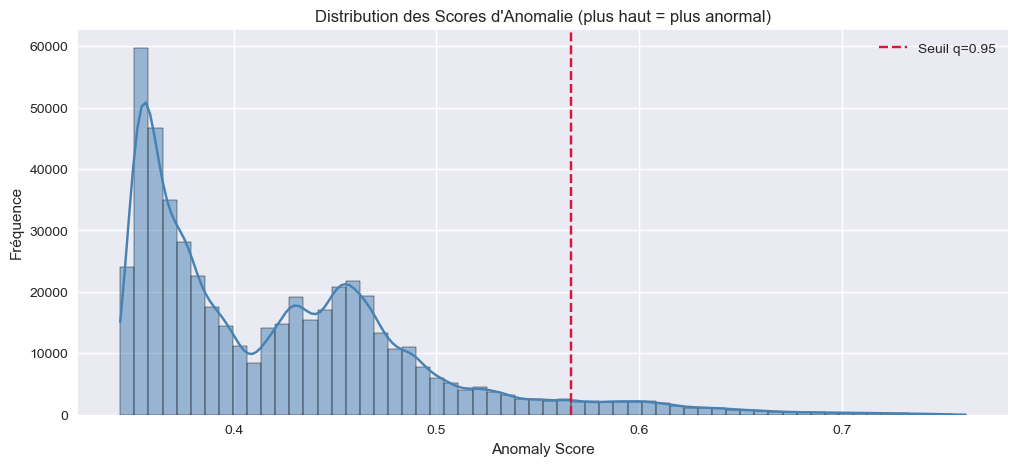

Anomalies (seuil q=0.95): 25,757 (5.00%)

Top 15 anomalies (plus grands scores):
        Invoice StockCode                         Description  Quantity    Price  LineAmount  CustomerID         Country  IsReturn  AnomalyScore
305504   519201     84991         60 TEATIME FAIRY CAKE CASES      1200     0.40      480.00     13027.0  United Kingdom     False      0.761180
305506   519201     21213         PACK OF 72 SKULL CAKE CASES       960     0.40      384.00     13027.0  United Kingdom     False      0.759123
305507   519201     21212    PACK OF 72 RETRO SPOT CAKE CASES       960     0.40      384.00     13027.0  United Kingdom     False      0.759123
519716   537666       DOT                      DOTCOM POSTAGE         1   701.95      701.95         NaN  United Kingdom     False      0.758184
461644   533027     22086      PAPER CHAIN KIT 50'S CHRISTMAS       835     6.95     5803.25         NaN  United Kingdom     False      0.757593
62600    494918     20748               KENSINGTO

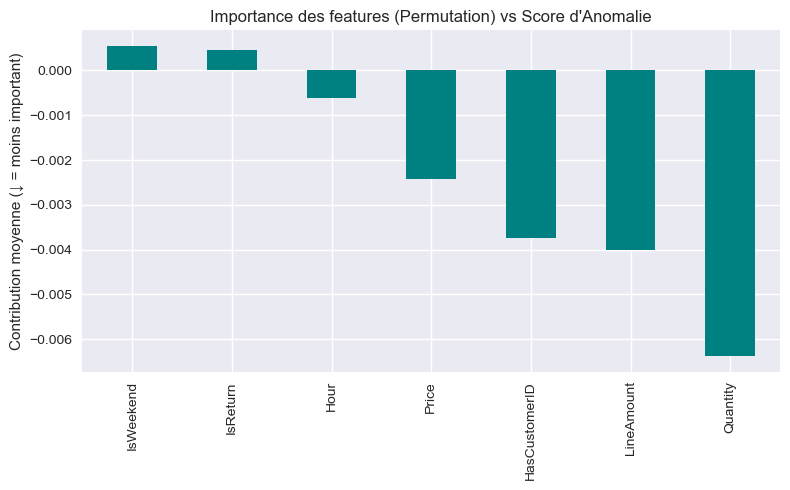

In [19]:
# Scores d'anomalie, seuils et top anomalies

from sklearn.inspection import permutation_importance

# Recalcule des scores bruts si nécessaire
iso = IsolationForest(contamination=0.08, random_state=42)
iso.fit(X_anom)
raw_scores = -iso.score_samples(X_anom)  # plus GRAND = plus anormal
anomaly_df['AnomalyScore'] = raw_scores

# Explorer plusieurs seuils (quantiles)
quantiles = [0.99, 0.98, 0.95, 0.90]
thresholds = {q: np.quantile(raw_scores, q) for q in quantiles}

print('Seuils (quantiles) possibles:')
for q, t in thresholds.items():
    print(f"  q={q:.2f} → seuil={t:.4f}, anomalies≈{(raw_scores>=t).mean():.2%}")

# Choix d'un seuil «visuel» par défaut
chosen_q = 0.95
threshold = thresholds[chosen_q]

# Histogramme/KDE des scores avec seuil
plt.figure(figsize=(12,5))
sns.histplot(raw_scores, bins=60, kde=True, color='steelblue')
plt.axvline(threshold, color='crimson', linestyle='--', label=f'Seuil q={chosen_q:.2f}')
plt.title("Distribution des Scores d'Anomalie (plus haut = plus anormal)")
plt.xlabel('Anomaly Score')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

# Appliquer le seuil choisi
anomaly_df['IsAnomaly_threshold'] = anomaly_df['AnomalyScore'] >= threshold
print(f"Anomalies (seuil q={chosen_q:.2f}): {anomaly_df['IsAnomaly_threshold'].sum():,} ({anomaly_df['IsAnomaly_threshold'].mean():.2%})")

# Top anomalies (plus gros scores)
print('\nTop 15 anomalies (plus grands scores):')
cols = ['Invoice','StockCode','Description','Quantity','Price','LineAmount','CustomerID','Country','IsReturn','AnomalyScore']
print(anomaly_df.sort_values('AnomalyScore', ascending=False).head(15)[cols])

# Importance des features (permutation) sur le score d'anomalie
print('\nImportance des features (permutation) sur le score:')
# On utilise une petite subsample pour accélérer si dataset très grand
sample_idx = np.random.choice(len(X_anom), size=min(5000, len(X_anom)), replace=False)
def anomaly_score_mean(estimator, X, y=None):
    return np.mean(-estimator.score_samples(X))

perm = permutation_importance(
    estimator=iso,
    X=X_anom.iloc[sample_idx],
    y=None,
    n_repeats=5,
    random_state=42,
    scoring=anomaly_score_mean
)
fi = pd.Series(perm.importances_mean, index=anomaly_features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
fi.plot(kind='bar', color='teal')
plt.title("Importance des features (Permutation) vs Score d'Anomalie")
plt.ylabel('Contribution moyenne (↓ = moins important)')
plt.tight_layout()
plt.show()


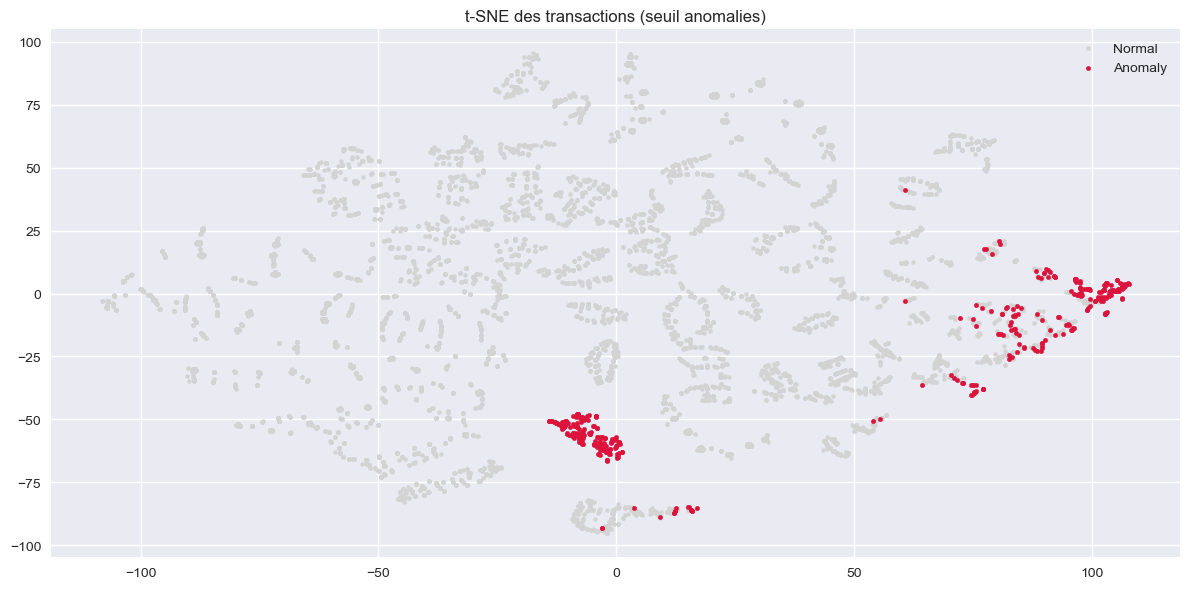

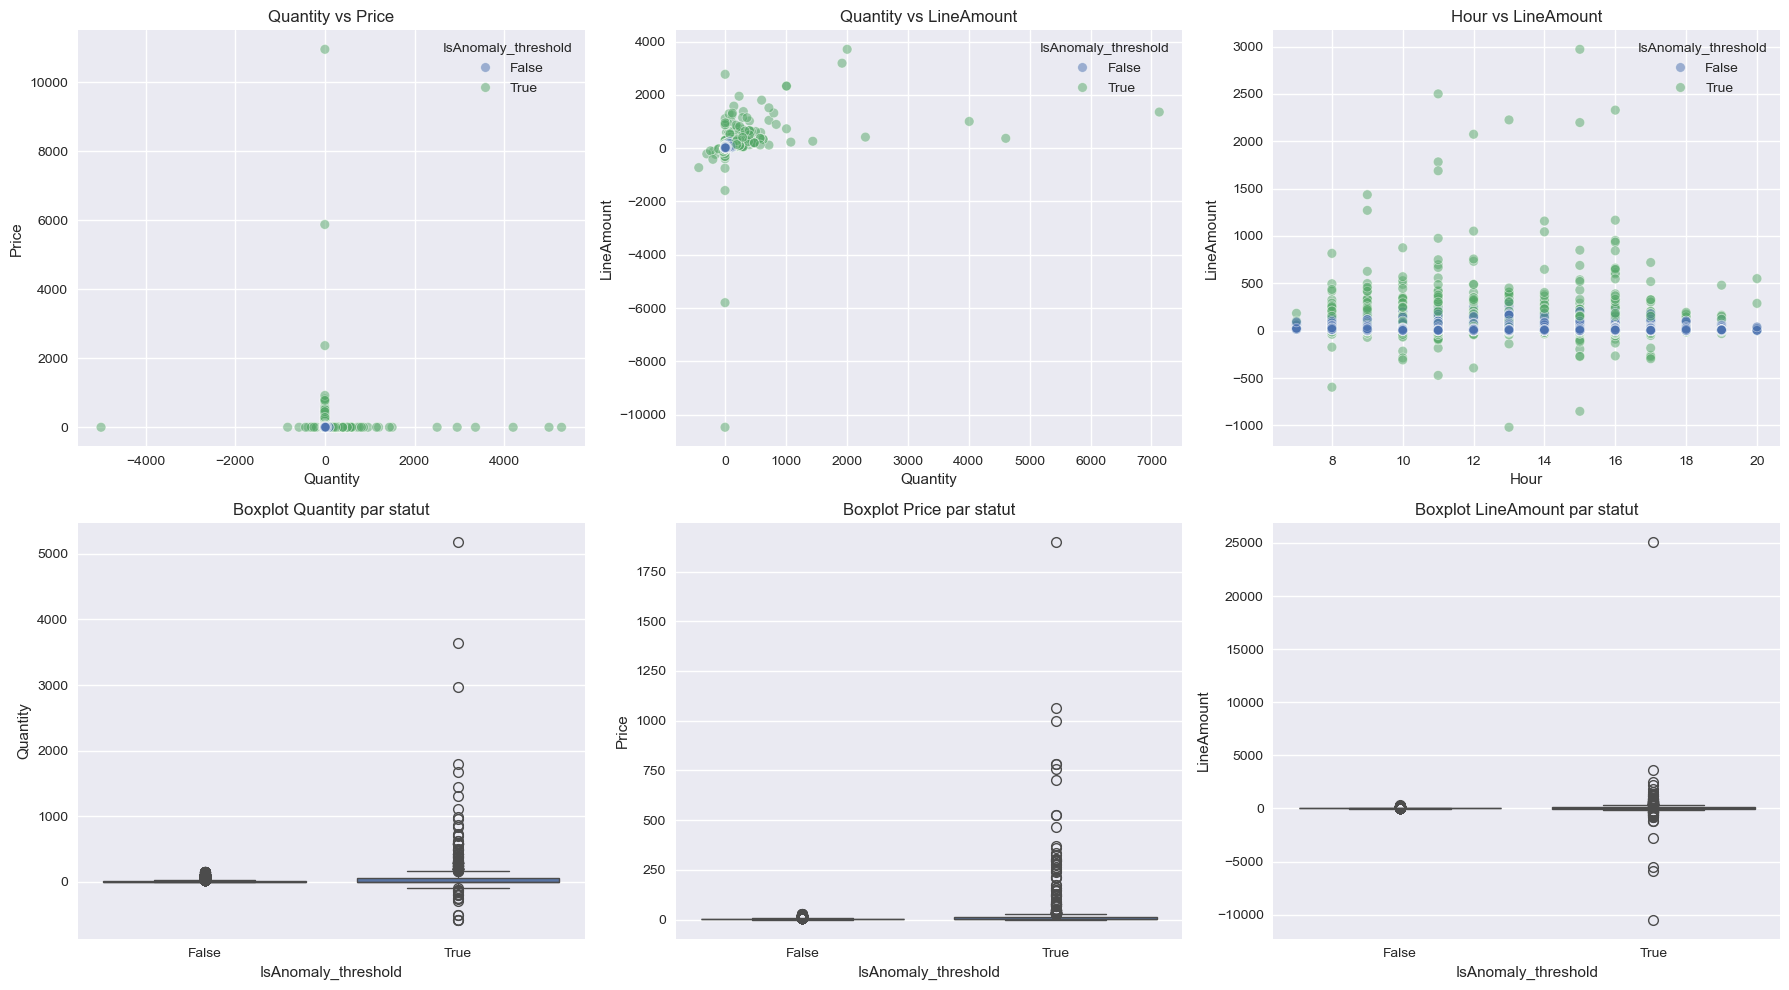

In [20]:
# Vue 2D plus lisible (t-SNE) et graphiques ciblés

from sklearn.manifold import TSNE

# Échantillon pour t-SNE si dataset très grand
tsne_idx = np.random.choice(len(X_anom), size=min(8000, len(X_anom)), replace=False)
X_tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42, perplexity=30).fit_transform(X_anom.iloc[tsne_idx])
mask_anom = anomaly_df.iloc[tsne_idx]['IsAnomaly_threshold'].values

plt.figure(figsize=(12,6))
plt.scatter(X_tsne[~mask_anom,0], X_tsne[~mask_anom,1], c='lightgray', s=8, label='Normal')
plt.scatter(X_tsne[mask_anom,0], X_tsne[mask_anom,1], c='crimson', s=10, label='Anomaly')
plt.title('t-SNE des transactions (seuil anomalies)')
plt.legend()
plt.tight_layout()
plt.show()

# Graphiques ciblés: relations entre variables clés
fig, axes = plt.subplots(2, 3, figsize=(18,10))

# Quantity vs Price
sns.scatterplot(data=anomaly_df.sample(min(20000, len(anomaly_df))), x='Quantity', y='Price', hue='IsAnomaly_threshold', alpha=0.5, ax=axes[0,0])
axes[0,0].set_title('Quantity vs Price')

# Quantity vs LineAmount
sns.scatterplot(data=anomaly_df.sample(min(20000, len(anomaly_df))), x='Quantity', y='LineAmount', hue='IsAnomaly_threshold', alpha=0.5, ax=axes[0,1])
axes[0,1].set_title('Quantity vs LineAmount')

# Hour vs LineAmount
sns.scatterplot(data=anomaly_df.sample(min(20000, len(anomaly_df))), x='Hour', y='LineAmount', hue='IsAnomaly_threshold', alpha=0.5, ax=axes[0,2])
axes[0,2].set_title('Hour vs LineAmount')

# Boxplots par statut anomalie
sns.boxplot(data=anomaly_df.sample(min(30000, len(anomaly_df))), x='IsAnomaly_threshold', y='Quantity', ax=axes[1,0])
axes[1,0].set_title('Boxplot Quantity par statut')

sns.boxplot(data=anomaly_df.sample(min(30000, len(anomaly_df))), x='IsAnomaly_threshold', y='Price', ax=axes[1,1])
axes[1,1].set_title('Boxplot Price par statut')

sns.boxplot(data=anomaly_df.sample(min(30000, len(anomaly_df))), x='IsAnomaly_threshold', y='LineAmount', ax=axes[1,2])
axes[1,2].set_title('Boxplot LineAmount par statut')

plt.tight_layout()
plt.show()


Taux d'anomalies par attribut:

HasCustomerID:
HasCustomerID
False    0.050143
True     0.049991
Name: IsAnomaly_threshold, dtype: float64

IsReturn:
IsReturn
False    0.031278
True     0.979275
Name: IsAnomaly_threshold, dtype: float64

Hour:
Hour
7     0.251344
8     0.090086
9     0.057077
10    0.073667
11    0.055892
12    0.039903
13    0.038363
14    0.033088
15    0.047459
16    0.057293
17    0.055222
18    0.083624
19    0.087860
20    0.106834
21    1.000000
Name: IsAnomaly_threshold, dtype: float64

Country_top10:
Country
Hong Kong          0.342105
Japan              0.334821
Netherlands        0.276473
Sweden             0.234184
Denmark            0.175234
Korea              0.158730
Lebanon            0.153846
RSA                0.144144
Australia          0.129969
Channel Islands    0.126932
Name: IsAnomaly_threshold, dtype: float64


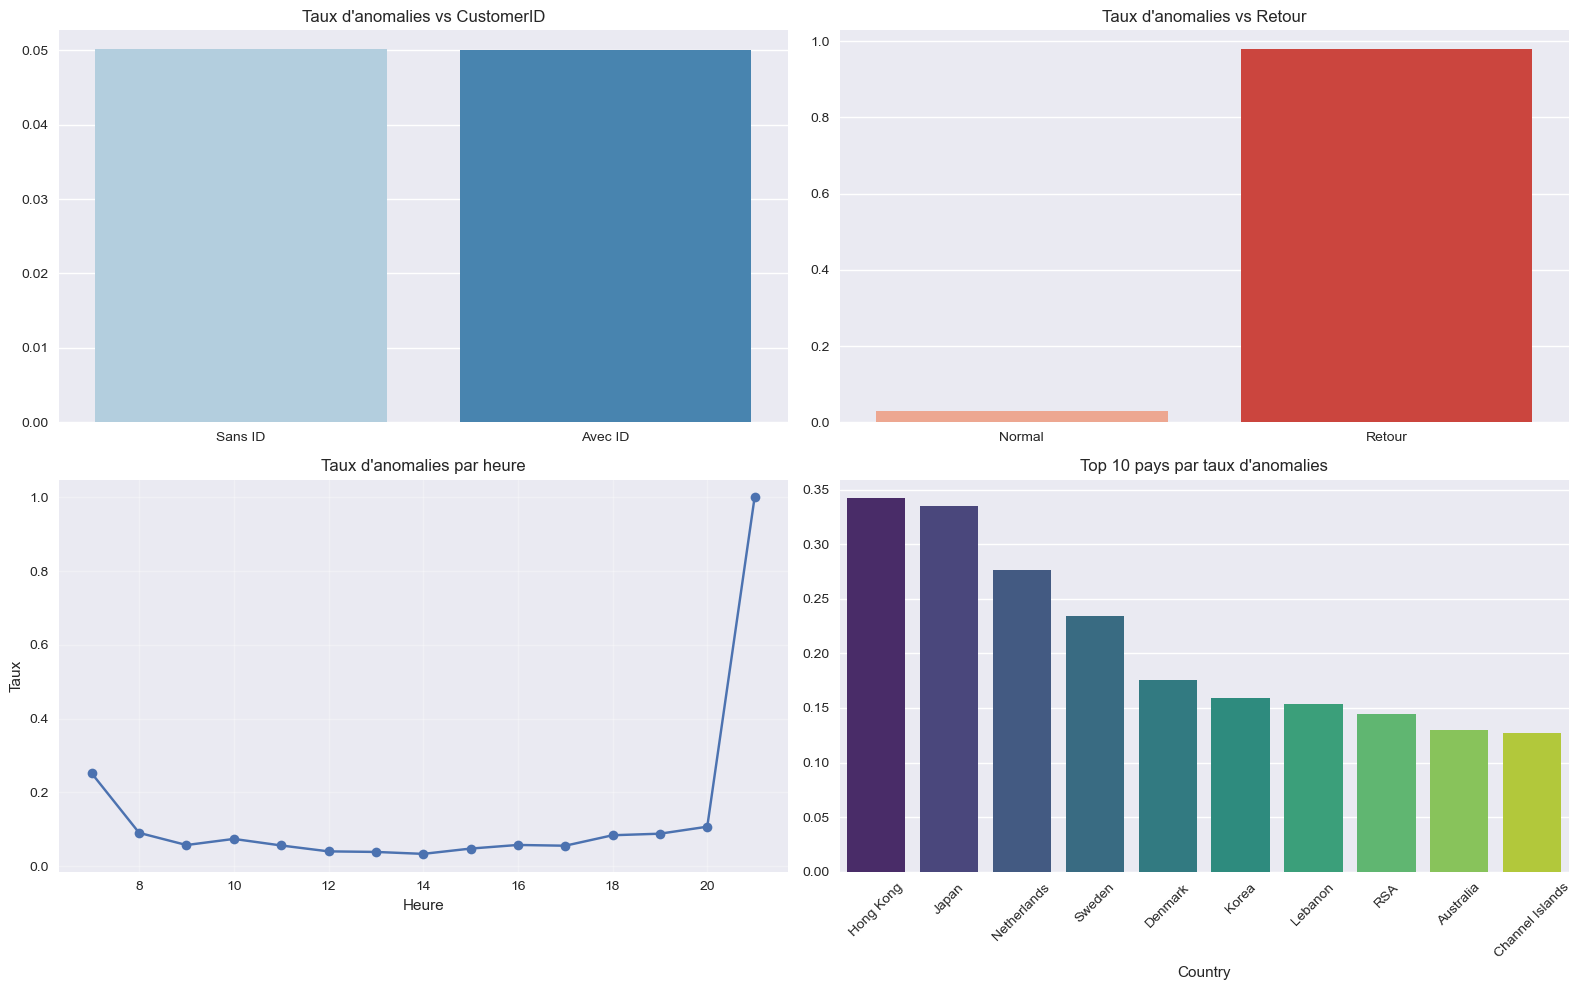

In [21]:
# Découpage des anomalies par attributs business

summary = {}
summary['HasCustomerID'] = anomaly_df.groupby('HasCustomerID')['IsAnomaly_threshold'].mean()
summary['IsReturn'] = anomaly_df.groupby('IsReturn')['IsAnomaly_threshold'].mean()
summary['Hour'] = anomaly_df.groupby('Hour')['IsAnomaly_threshold'].mean()

# Top 10 pays avec plus d'anomalies (taux)
country_rates = anomaly_df.groupby('Country')['IsAnomaly_threshold'].mean().sort_values(ascending=False)
summary['Country_top10'] = country_rates.head(10)

print('Taux d\'anomalies par attribut:')
for k, v in summary.items():
    print(f"\n{k}:")
    print(v)

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(16,10))

sns.barplot(x=['Sans ID','Avec ID'], y=summary['HasCustomerID'].values, ax=axes[0,0], palette='Blues')
axes[0,0].set_title("Taux d'anomalies vs CustomerID")

sns.barplot(x=['Normal','Retour'], y=summary['IsReturn'].values, ax=axes[0,1], palette='Reds')
axes[0,1].set_title("Taux d'anomalies vs Retour")

axes[1,0].plot(summary['Hour'].index, summary['Hour'].values, marker='o')
axes[1,0].set_title("Taux d'anomalies par heure")
axes[1,0].set_xlabel('Heure')
axes[1,0].set_ylabel('Taux')
axes[1,0].grid(True, alpha=0.3)

sns.barplot(x=summary['Country_top10'].index, y=summary['Country_top10'].values, ax=axes[1,1], palette='viridis')
axes[1,1].set_title("Top 10 pays par taux d'anomalies")
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


##  DBSCAN comme Détecteur d'Anomalies (Transaction-level)

- Idée: les points «isolés» dans l'espace des features (faible densité) sont labellisés comme bruit = anomalies (`label = -1`).
- Nécessite `eps` (rayon) et `min_samples` (voisins requis). On utilise le k-distance plot pour choisir `eps`.


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np

# On repart de la même base que pour Isolation Forest
dbscan_df = anomaly_df.copy()

# Les mêmes features que tu as utilisés pour IsolationForest
anomaly_features = ['Quantity', 'Price', 'LineAmount', 'IsReturn', 'HasCustomerID', 'Hour', 'IsWeekend']

X_raw = dbscan_df[anomaly_features].fillna(0)

# DBSCAN est basé sur les distances → on normalise
scaler_db = StandardScaler()
X_scaled = scaler_db.fit_transform(X_raw)

print("Shape des données pour DBSCAN:", X_scaled.shape)


Shape des données pour DBSCAN: (514915, 7)


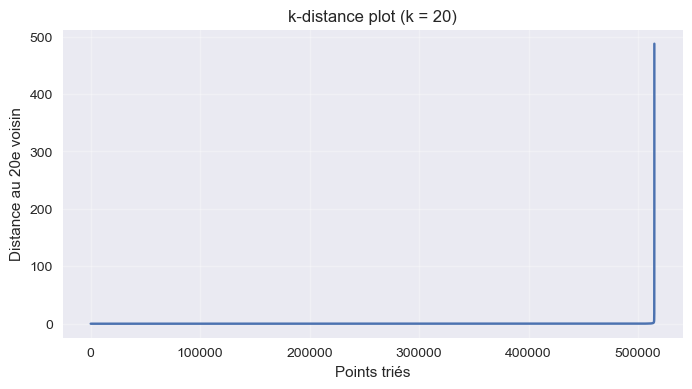

In [23]:
import matplotlib.pyplot as plt

min_samples = 20  # tu peux ajuster (10, 15, 20...). Plus grand = plus strict

# k-NN: distance jusqu'au min_samples-ième voisin
nbrs = NearestNeighbors(n_neighbors=min_samples)
nbrs.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# On prend la distance au k-ième voisin (colonne -1)
k_dist = np.sort(distances[:, -1])

plt.figure(figsize=(8,4))
plt.plot(k_dist)
plt.title(f"k-distance plot (k = {min_samples})")
plt.xlabel("Points triés")
plt.ylabel(f"Distance au {min_samples}e voisin")
plt.grid(alpha=0.3)
plt.show()


In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

dbscan_df = anomaly_df.copy()

anomaly_features = ['Quantity', 'Price', 'LineAmount', 'IsReturn', 'HasCustomerID', 'Hour', 'IsWeekend']
X_raw = dbscan_df[anomaly_features].fillna(0)

MAX_POINTS = 50000  # shrink if you still hit MemoryError
if len(X_raw) > MAX_POINTS:
    sample_idx = np.random.choice(X_raw.index, size=MAX_POINTS, replace=False)
else:
    sample_idx = X_raw.index

X_sample = X_raw.loc[sample_idx]

scaler_db = StandardScaler()
X_scaled_sample = scaler_db.fit_transform(X_sample)

eps_value = 2.0
min_samples = 20

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
db_labels_sample = dbscan.fit_predict(X_scaled_sample)

dbscan_results = pd.DataFrame({
    'DBSCAN_Label': db_labels_sample,
    'IsAnomaly_DBSCAN': (db_labels_sample == -1)
}, index=sample_idx)

dbscan_df = dbscan_df.join(dbscan_results, how='left')

print("Label distribution (sample only):")
print(dbscan_df['DBSCAN_Label'].value_counts(dropna=False).sort_index())
print("DBSCAN anomaly rate (sample only):", dbscan_df['IsAnomaly_DBSCAN'].mean())


Label distribution (sample only):
DBSCAN_Label
-1.0       153
 0.0     10033
 1.0     31939
 2.0      6857
 3.0        66
 4.0       860
 5.0        58
 6.0        34
 NaN    464915
Name: count, dtype: int64
DBSCAN anomaly rate (sample only): 0.00306


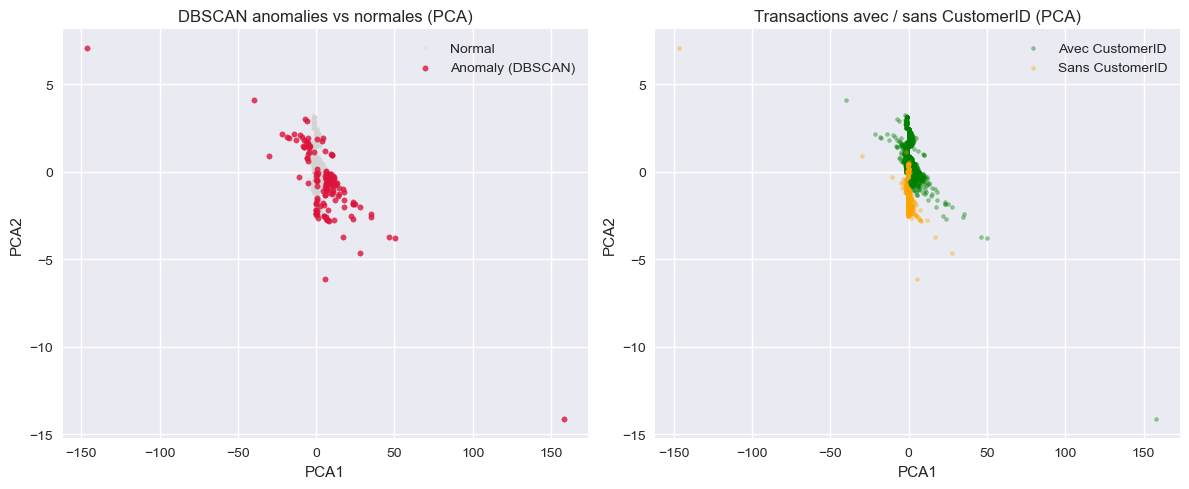

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. We only plot rows that DBSCAN actually labeled (i.e. part of the 50k sample)
labeled_mask = ~dbscan_df['DBSCAN_Label'].isna()

plot_df = dbscan_df.loc[labeled_mask].copy()

# Features used for DBSCAN
anomaly_features = ['Quantity', 'Price', 'LineAmount', 'IsReturn', 'HasCustomerID', 'Hour', 'IsWeekend']
X_plot_raw = plot_df[anomaly_features].fillna(0)

# scale + PCA to 2D for visualization
scaler_plot = StandardScaler()
X_plot_scaled = scaler_plot.fit_transform(X_plot_raw)

pca_vis = PCA(n_components=2, random_state=42)
X_pca_vis = pca_vis.fit_transform(X_plot_scaled)

plot_df['PCA1'] = X_pca_vis[:,0]
plot_df['PCA2'] = X_pca_vis[:,1]

# Safety: create boolean anomaly column from DBSCAN
plot_df['IsAnomaly_DBSCAN'] = (plot_df['DBSCAN_Label'] == -1)

# 2. Now we actually plot
plt.figure(figsize=(12,5))

# ---- (A) Normal vs Anomaly according to DBSCAN ----
plt.subplot(1,2,1)
plt.scatter(
    plot_df.loc[~plot_df['IsAnomaly_DBSCAN'], 'PCA1'],
    plot_df.loc[~plot_df['IsAnomaly_DBSCAN'], 'PCA2'],
    c='lightgray',
    s=8,
    alpha=0.3,
    label='Normal'
)
plt.scatter(
    plot_df.loc[plot_df['IsAnomaly_DBSCAN'], 'PCA1'],
    plot_df.loc[plot_df['IsAnomaly_DBSCAN'], 'PCA2'],
    c='crimson',
    s=15,
    alpha=0.8,
    label='Anomaly (DBSCAN)'
)
plt.title("DBSCAN anomalies vs normales (PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()

# ---- (B) With vs without CustomerID ----
plt.subplot(1,2,2)
plt.scatter(
    plot_df.loc[plot_df['HasCustomerID'] == 1, 'PCA1'],
    plot_df.loc[plot_df['HasCustomerID'] == 1, 'PCA2'],
    c='green',
    s=8,
    alpha=0.4,
    label='Avec CustomerID'
)
plt.scatter(
    plot_df.loc[plot_df['HasCustomerID'] == 0, 'PCA1'],
    plot_df.loc[plot_df['HasCustomerID'] == 0, 'PCA2'],
    c='orange',
    s=8,
    alpha=0.4,
    label='Sans CustomerID'
)
plt.title("Transactions avec / sans CustomerID (PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()

plt.tight_layout()
plt.show()


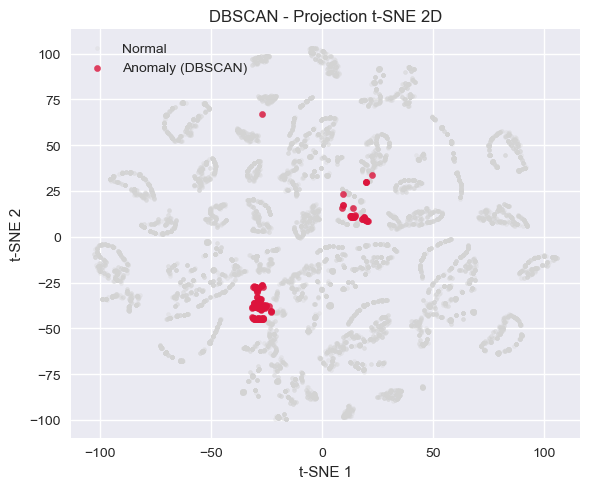

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Garde uniquement les lignes qui ont reçu un label DBSCAN
labeled_mask = ~dbscan_df['DBSCAN_Label'].isna()
tsne_df = dbscan_df.loc[labeled_mask].copy()

# Sélectionne les features utilisées pour DBSCAN
anomaly_features = ['Quantity', 'Price', 'LineAmount', 'IsReturn', 'HasCustomerID', 'Hour', 'IsWeekend']
X_full = tsne_df[anomaly_features].fillna(0).to_numpy()

# Sépare anomalies / normales
is_anom = (tsne_df['DBSCAN_Label'] == -1)

# Pour l'échantillonnage : on veut garder TOUTES les anomalies, plus un sous-échantillon de normales
NORMAL_MAX = 10000  # tu peux réduire si t-SNE est trop lent
anom_idx = np.where(is_anom)[0]
norm_idx = np.where(~is_anom)[0]

if len(norm_idx) > NORMAL_MAX:
    norm_idx_sampled = np.random.choice(norm_idx, size=NORMAL_MAX, replace=False)
else:
    norm_idx_sampled = norm_idx

keep_idx = np.concatenate([anom_idx, norm_idx_sampled])
X_keep = X_full[keep_idx]
is_anom_keep = is_anom.to_numpy()[keep_idx]

# Scaling indispensable avant t-SNE
scaler_tsne = StandardScaler()
X_keep_scaled = scaler_tsne.fit_transform(X_keep)

# t-SNE 2D
tsne = TSNE(
    n_components=2,
    learning_rate='auto',
    init='random',
    perplexity=30,
    random_state=42
)
X_tsne_2d = tsne.fit_transform(X_keep_scaled)

# DataFrame pour plot
tsne_plot = pd.DataFrame({
    'TSNE1': X_tsne_2d[:,0],
    'TSNE2': X_tsne_2d[:,1],
    'IsAnomaly_DBSCAN': is_anom_keep.astype(bool)
})

plt.figure(figsize=(6,5))
plt.scatter(
    tsne_plot.loc[~tsne_plot['IsAnomaly_DBSCAN'], 'TSNE1'],
    tsne_plot.loc[~tsne_plot['IsAnomaly_DBSCAN'], 'TSNE2'],
    c='lightgray',
    s=8,
    alpha=0.3,
    label='Normal'
)
plt.scatter(
    tsne_plot.loc[tsne_plot['IsAnomaly_DBSCAN'], 'TSNE1'],
    tsne_plot.loc[tsne_plot['IsAnomaly_DBSCAN'], 'TSNE2'],
    c='crimson',
    s=20,
    alpha=0.8,
    label='Anomaly (DBSCAN)'
)
plt.title("DBSCAN - Projection t-SNE 2D")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
# Sous-ensemble: seulement les lignes labellisées par DBSCAN
labeled_mask = ~dbscan_df['DBSCAN_Label'].isna()
focus_df = dbscan_df.loc[labeled_mask].copy()

focus_df['IsAnomaly_DBSCAN'] = (focus_df['DBSCAN_Label'] == -1)

anom_db = focus_df[focus_df['IsAnomaly_DBSCAN'] == True].copy()
norm_db = focus_df[focus_df['IsAnomaly_DBSCAN'] == False].copy()

print("Taille normales (échantillonées DBSCAN):", len(norm_db))
print("Taille anomalies DBSCAN:", len(anom_db))
print("Anomaly rate dans l'échantillon labellisé:", 
      len(anom_db) / len(focus_df))


Taille normales (échantillonées DBSCAN): 49847
Taille anomalies DBSCAN: 153
Anomaly rate dans l'échantillon labellisé: 0.00306


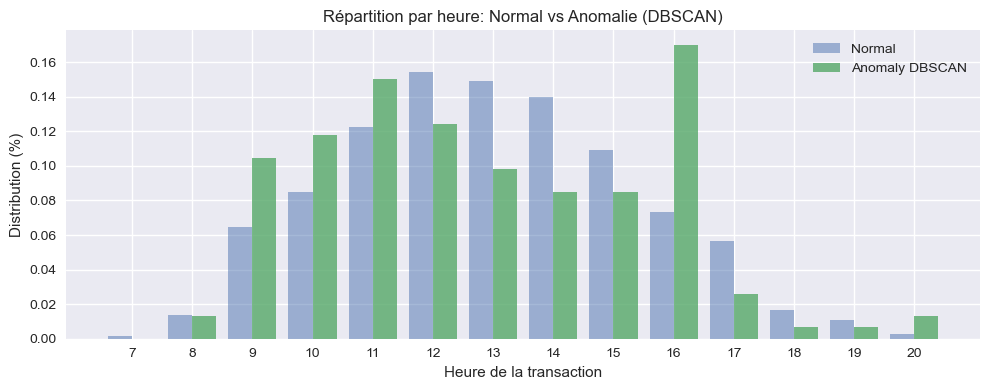

In [28]:
import matplotlib.pyplot as plt

hour_anom = anom_db['Hour'].value_counts(normalize=True).sort_index()
hour_norm = norm_db['Hour'].value_counts(normalize=True).sort_index()

all_hours = sorted(set(hour_norm.index).union(hour_anom.index))

anom_rates = [hour_anom.get(h, 0) for h in all_hours]
norm_rates = [hour_norm.get(h, 0) for h in all_hours]

plt.figure(figsize=(10,4))
bar_w = 0.4
xpos = np.arange(len(all_hours))

plt.bar(xpos - bar_w/2, norm_rates, width=bar_w, alpha=0.5, label='Normal')
plt.bar(xpos + bar_w/2, anom_rates, width=bar_w, alpha=0.8, label='Anomaly DBSCAN')

plt.xticks(xpos, all_hours)
plt.xlabel("Heure de la transaction")
plt.ylabel("Distribution (%)")
plt.title("Répartition par heure: Normal vs Anomalie (DBSCAN)")
plt.legend()
plt.tight_layout()
plt.show()


COMPARAISON ISOLATION FOREST VS DBSCAN

In [29]:
import pandas as pd
from sklearn.metrics import classification_report

# 1. Fusion des résultats Isolation Forest + DBSCAN
# On garde aussi DBSCAN_Label pour debug
compare_df = anomaly_df.join(
    dbscan_df[['IsAnomaly_DBSCAN', 'DBSCAN_Label']],
    how='left',  # left = on garde toutes les lignes d'Isolation Forest
    rsuffix='_db'
)

print("Dim compare_df:", compare_df.shape)

# 2. Stats globales
iso_rate = compare_df['IsAnomaly'].mean()
db_rate  = compare_df['IsAnomaly_DBSCAN'].mean()  # attention: NaN inclus va baisser artificiellement

db_rate_overlap = compare_df.loc[~compare_df['IsAnomaly_DBSCAN'].isna(), 'IsAnomaly_DBSCAN'].mean()

print(f"Taux d'anomalies Isolation Forest (sur tout l'échantillon IF): {iso_rate:.4f}")
print(f"Taux d'anomalies DBSCAN (sur toutes les lignes, NaN inclus): {db_rate:.4f}")
print(f"Taux d'anomalies DBSCAN (UNIQUEMENT là où DBSCAN a donné un label): {db_rate_overlap:.4f}")

# 3. Matrice de confusion croisée sur la zone d'overlap
overlap_mask = ~compare_df['IsAnomaly_DBSCAN'].isna()
overlap = compare_df.loc[overlap_mask, ['IsAnomaly', 'IsAnomaly_DBSCAN']].copy()

crosstab_norm = pd.crosstab(
    overlap['IsAnomaly'],
    overlap['IsAnomaly_DBSCAN'],
    rownames=['IsolationForest'],
    colnames=['DBSCAN'],
    normalize='index'  # pourcentage par ligne
)
crosstab_raw = pd.crosstab(
    overlap['IsAnomaly'],
    overlap['IsAnomaly_DBSCAN'],
    rownames=['IsolationForest'],
    colnames=['DBSCAN'],
    normalize=False
)

print("\nMatrice de comparaison NORMALISÉE (pourcentages par ligne Isolation Forest):")
print(crosstab_norm)

print("\nMatrice de comparaison BRUTE (nombre de lignes):")
print(crosstab_raw)

# 4. Rapport type classification_report
# On traite Isolation Forest comme 'vérité terrain' (référence interne)
y_true = overlap['IsAnomaly'].astype(int)
y_pred = overlap['IsAnomaly_DBSCAN'].astype(int)

print("\nDBSCAN vs Isolation Forest (IF comme référence):")
print(classification_report(
    y_true,
    y_pred,
    target_names=['Normal(IF)', 'Anomaly(IF)']
))

# 5. On regarde les cas où Isolation Forest dit ANOMALIE mais pas DBSCAN
false_neg_dbscan = compare_df.loc[
    (compare_df['IsAnomaly'] == True) &
    (compare_df['IsAnomaly_DBSCAN'] == False)
]

print("\nExemples: IF = Anomaly, DBSCAN = Normal")
print(false_neg_dbscan[['Quantity','Price','LineAmount','IsReturn','HasCustomerID','Hour','IsWeekend','DBSCAN_Label']].head(10))

# 6. Et l'inverse: DBSCAN dit ANOMALIE mais pas Isolation Forest
false_pos_dbscan = compare_df.loc[
    (compare_df['IsAnomaly'] == False) &
    (compare_df['IsAnomaly_DBSCAN'] == True)
]

print("\nExemples: DBSCAN = Anomaly, IF = Normal")
print(false_pos_dbscan[['Quantity','Price','LineAmount','IsReturn','HasCustomerID','Hour','IsWeekend','DBSCAN_Label']].head(10))


Dim compare_df: (514915, 18)
Taux d'anomalies Isolation Forest (sur tout l'échantillon IF): 0.0800
Taux d'anomalies DBSCAN (sur toutes les lignes, NaN inclus): 0.0031
Taux d'anomalies DBSCAN (UNIQUEMENT là où DBSCAN a donné un label): 0.0031

Matrice de comparaison NORMALISÉE (pourcentages par ligne Isolation Forest):
DBSCAN              False     True 
IsolationForest                    
False            1.000000  0.000000
True             0.961393  0.038607

Matrice de comparaison BRUTE (nombre de lignes):
DBSCAN           False  True 
IsolationForest              
False            46037      0
True              3810    153

DBSCAN vs Isolation Forest (IF comme référence):
              precision    recall  f1-score   support

  Normal(IF)       0.92      1.00      0.96     46037
 Anomaly(IF)       1.00      0.04      0.07      3963

    accuracy                           0.92     50000
   macro avg       0.96      0.52      0.52     50000
weighted avg       0.93      0.92      0.89 

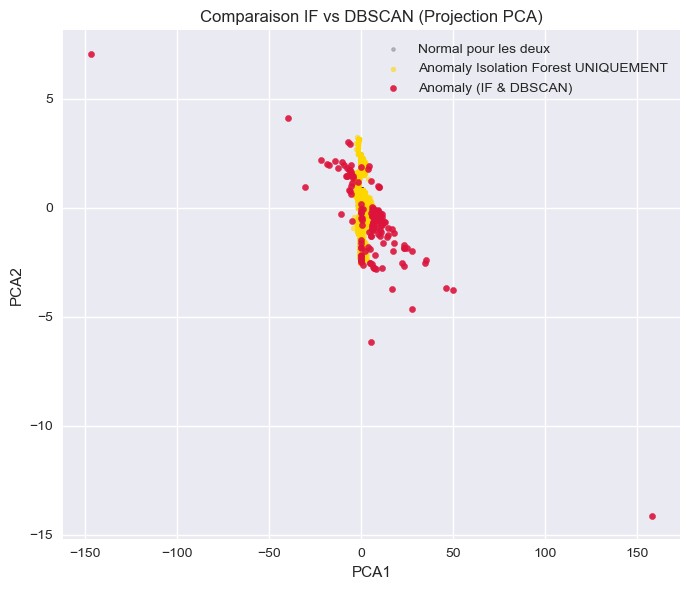

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# On se limite aux lignes où DBSCAN a donné un label (sinon on ne peut pas comparer)
overlap_mask = ~compare_df['IsAnomaly_DBSCAN'].isna()
viz_df = compare_df.loc[overlap_mask].copy()

# Catégories:
# 0 = normal pour les deux
# 1 = anomalie Isolation Forest seulement
# 2 = anomalie pour les deux (IF+DBSCAN)
def label_row(row):
    if row['IsAnomaly'] and row['IsAnomaly_DBSCAN']:
        return 2
    elif row['IsAnomaly'] and not row['IsAnomaly_DBSCAN']:
        return 1
    else:
        return 0

viz_df['CompareLabel'] = viz_df.apply(label_row, axis=1)

# Features utilisées pour l'analyse
anomaly_features = ['Quantity', 'Price', 'LineAmount', 'IsReturn', 'HasCustomerID', 'Hour', 'IsWeekend']
X_raw = viz_df[anomaly_features].fillna(0)

# PCA 2D
scaler_cmp = StandardScaler()
X_scaled_cmp = scaler_cmp.fit_transform(X_raw)

pca_cmp = PCA(n_components=2, random_state=42)
X_pca_cmp = pca_cmp.fit_transform(X_scaled_cmp)

viz_df['PCA1'] = X_pca_cmp[:,0]
viz_df['PCA2'] = X_pca_cmp[:,1]

# Plot
plt.figure(figsize=(7,6))

# normal (0)
plt.scatter(
    viz_df.loc[viz_df['CompareLabel'] == 0, 'PCA1'],
    viz_df.loc[viz_df['CompareLabel'] == 0, 'PCA2'],
    c='black', s=8, alpha=0.25,
    label='Normal pour les deux'
)

# IF only (1)
plt.scatter(
    viz_df.loc[viz_df['CompareLabel'] == 1, 'PCA1'],
    viz_df.loc[viz_df['CompareLabel'] == 1, 'PCA2'],
    c='gold', s=12, alpha=0.6,
    label='Anomaly Isolation Forest UNIQUEMENT'
)

# both anomaly (2)
plt.scatter(
    viz_df.loc[viz_df['CompareLabel'] == 2, 'PCA1'],
    viz_df.loc[viz_df['CompareLabel'] == 2, 'PCA2'],
    c='crimson', s=20, alpha=0.9,
    label='Anomaly (IF & DBSCAN)'
)

plt.title("Comparaison IF vs DBSCAN (Projection PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.tight_layout()
plt.show()


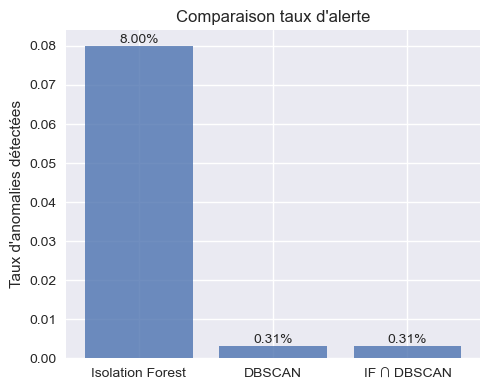

In [31]:
import matplotlib.pyplot as plt

# Recalcule les métriques qu'on a print
iso_rate = compare_df['IsAnomaly'].mean()

db_rate_overlap = compare_df.loc[
    ~compare_df['IsAnomaly_DBSCAN'].isna(),
    'IsAnomaly_DBSCAN'
].mean()

# overlap = % des lignes (dans overlap) qui sont anomalies pour les deux
both_mask = (
    (compare_df['IsAnomaly'] == True) &
    (compare_df['IsAnomaly_DBSCAN'] == True)
    & (~compare_df['IsAnomaly_DBSCAN'].isna())
)

overlap_base_mask = ~compare_df['IsAnomaly_DBSCAN'].isna()
both_rate = both_mask.sum() / overlap_base_mask.sum()

labels_bar = ['Isolation Forest', 'DBSCAN', 'IF ∩ DBSCAN']
values_bar = [iso_rate, db_rate_overlap, both_rate]

plt.figure(figsize=(5,4))
plt.bar(labels_bar, values_bar, alpha=0.8)
plt.ylabel("Taux d'anomalies détectées")
plt.title("Comparaison taux d'alerte")
for i, v in enumerate(values_bar):
    plt.text(i, v, f"{v*100:.2f}%", ha='center', va='bottom')
plt.tight_layout()
plt.show()


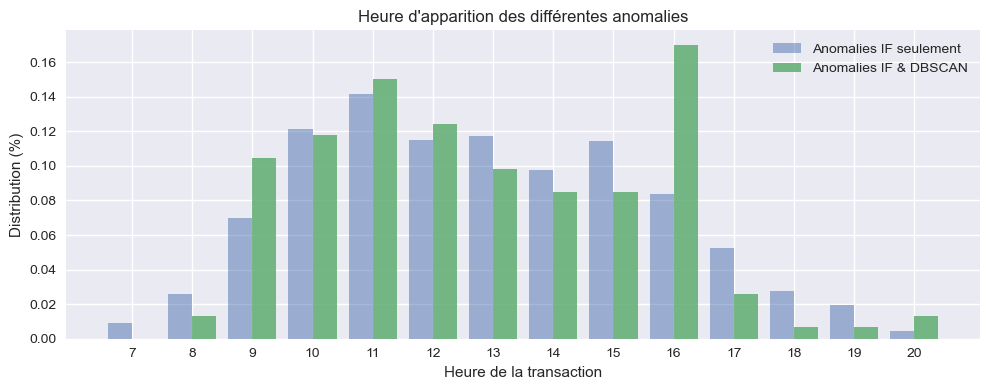

In [32]:
# Séparer les deux types d'anomalies
if_only = viz_df[viz_df['CompareLabel'] == 1]
both_anom = viz_df[viz_df['CompareLabel'] == 2]

hour_ifonly = if_only['Hour'].value_counts(normalize=True).sort_index()
hour_both   = both_anom['Hour'].value_counts(normalize=True).sort_index()

all_hours_cmp = sorted(set(hour_ifonly.index).union(hour_both.index))
ifonly_vals = [hour_ifonly.get(h, 0) for h in all_hours_cmp]
both_vals   = [hour_both.get(h, 0) for h in all_hours_cmp]

plt.figure(figsize=(10,4))
w = 0.4
xpos = np.arange(len(all_hours_cmp))

plt.bar(xpos - w/2, ifonly_vals, width=w, alpha=0.5, label='Anomalies IF seulement')
plt.bar(xpos + w/2, both_vals,   width=w, alpha=0.8, label='Anomalies IF & DBSCAN')

plt.xticks(xpos, all_hours_cmp)
plt.xlabel("Heure de la transaction")
plt.ylabel("Distribution (%)")
plt.title("Heure d'apparition des différentes anomalies")
plt.legend()
plt.tight_layout()
plt.show()
